In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -------------------------------
# Step 1: Define Paths and Params
# -------------------------------
image_size = (32, 32)
output_base = "/kaggle/working/hijja_digits_images"

os.makedirs(output_base, exist_ok=True)

# -------------------------------
# Step 2: Load CSV Data
# -------------------------------
X_train = pd.read_csv('/kaggle/input/hijjaa/X_train.csv').values
y_train = pd.read_csv('/kaggle/input/hijjaa/y_train.csv').values.ravel()

X_test = pd.read_csv('/kaggle/input/hijjaa/X_test.csv').values
y_test = pd.read_csv('/kaggle/input/hijjaa/y_test.csv').values.ravel()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# -------------------------------
# Step 3: Save Images to Folders
# -------------------------------
def save_images(X, y, split_name):
    for idx, (img_data, label) in enumerate(tqdm(zip(X, y), total=len(y))):
        img = img_data.reshape(32, 32).astype('uint8')
        img_resized = img  # Already 32x32

        class_dir = os.path.join(output_base, split_name, str(label))
        os.makedirs(class_dir, exist_ok=True)

        cv2.imwrite(os.path.join(class_dir, f"{idx}.png"), img_resized)

save_images(X_train, y_train, "train")
save_images(X_test, y_test, "test")

Train shape: (37933, 1024), Test shape: (9501, 1024)


100%|██████████| 9501/9501 [00:01<00:00, 8757.66it/s]


In [3]:
# -------------------------------
# Step 4: Create Validation Set
# -------------------------------
print("🔧 Splitting train into train + val...")

train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
os.makedirs(val_dir, exist_ok=True)

for digit_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, digit_class)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    val_class_dir = os.path.join(val_dir, digit_class)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_dir, img)
        os.rename(src, dst)

print("✅ Train, Val, Test sets are ready.")


🔧 Splitting train into train + val...
✅ Train, Val, Test sets are ready.


📷 Visualizing from Train Set Samples...


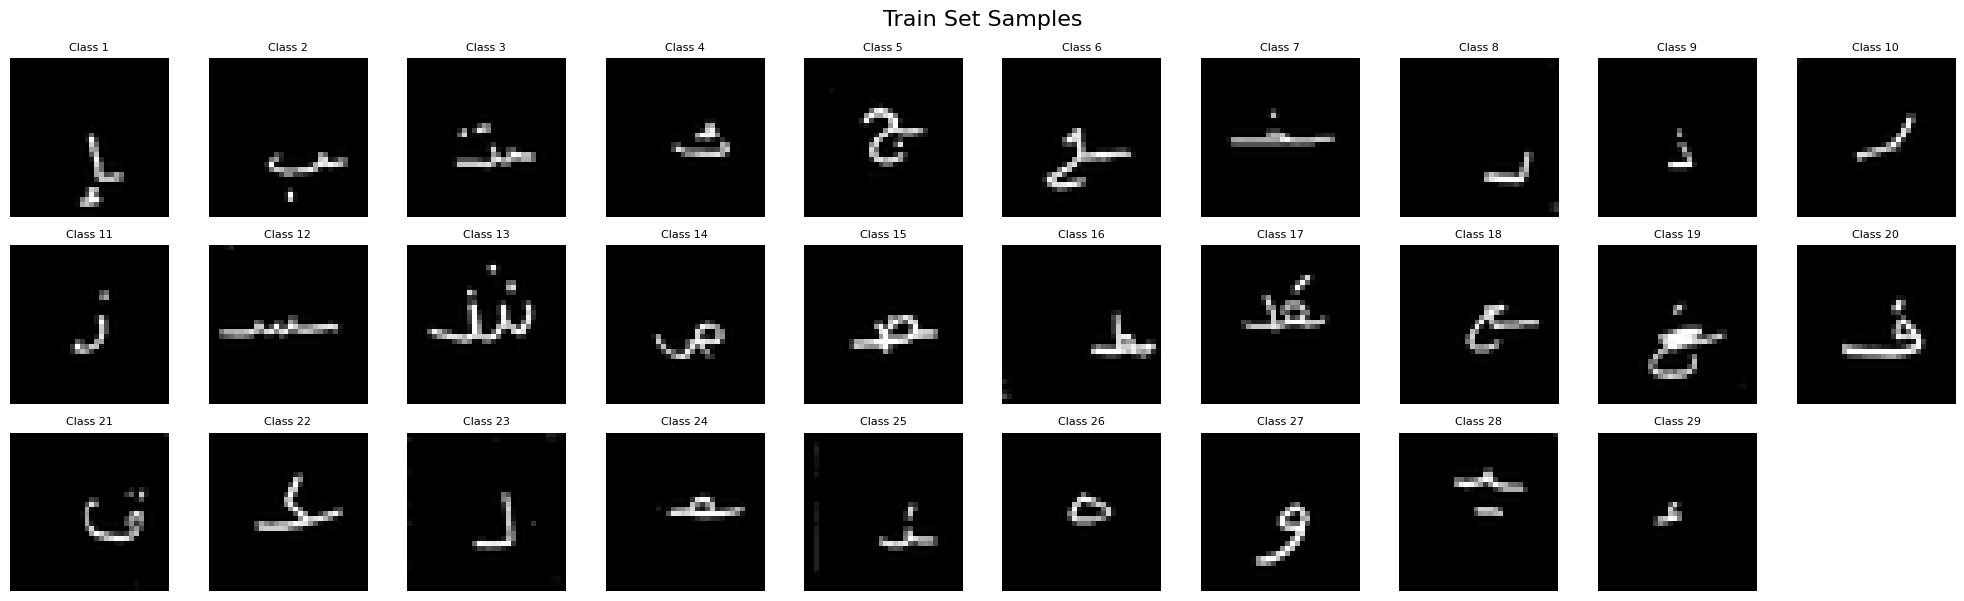

📷 Visualizing from Validation Set Samples...


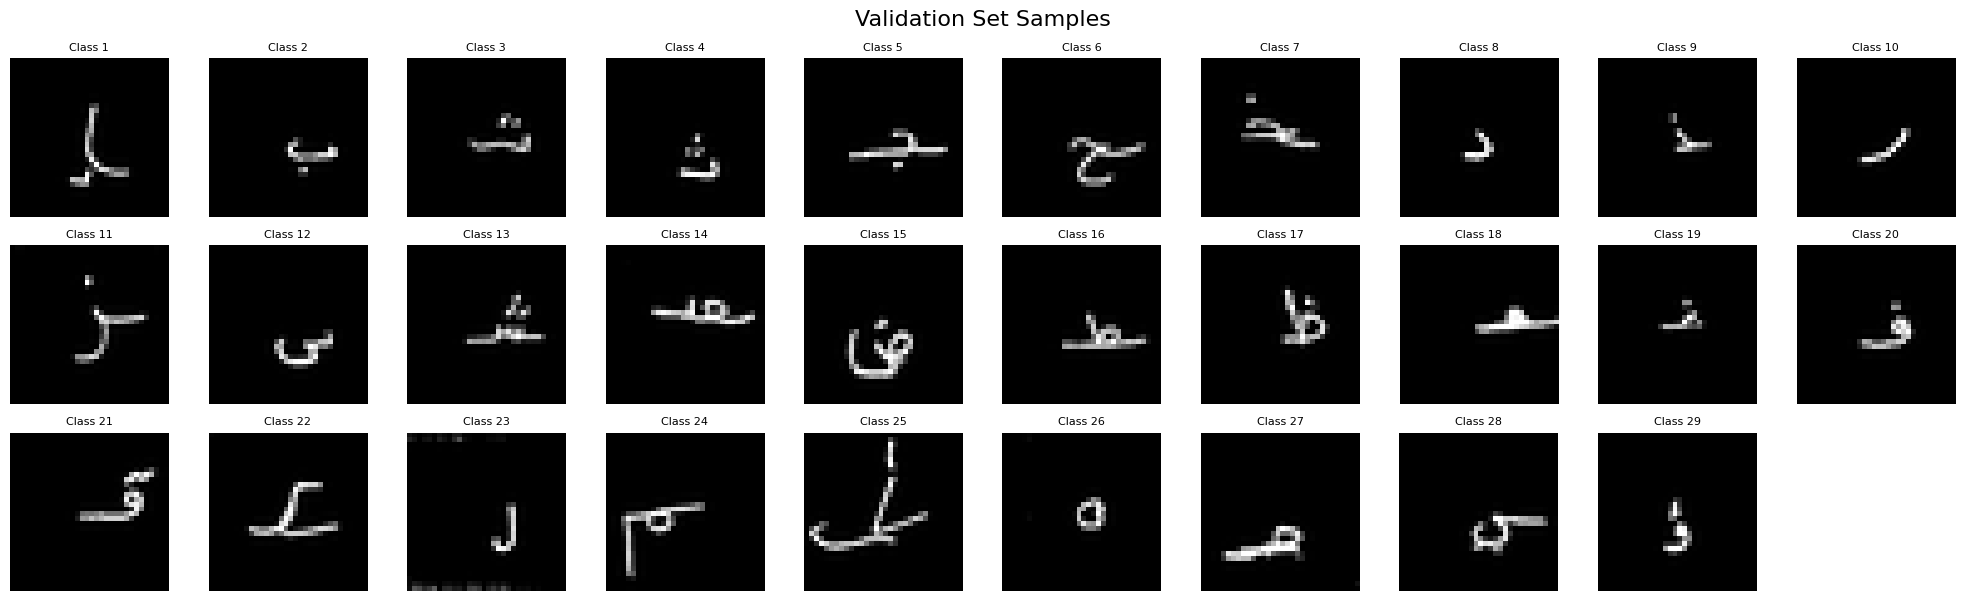

📷 Visualizing from Test Set Samples...


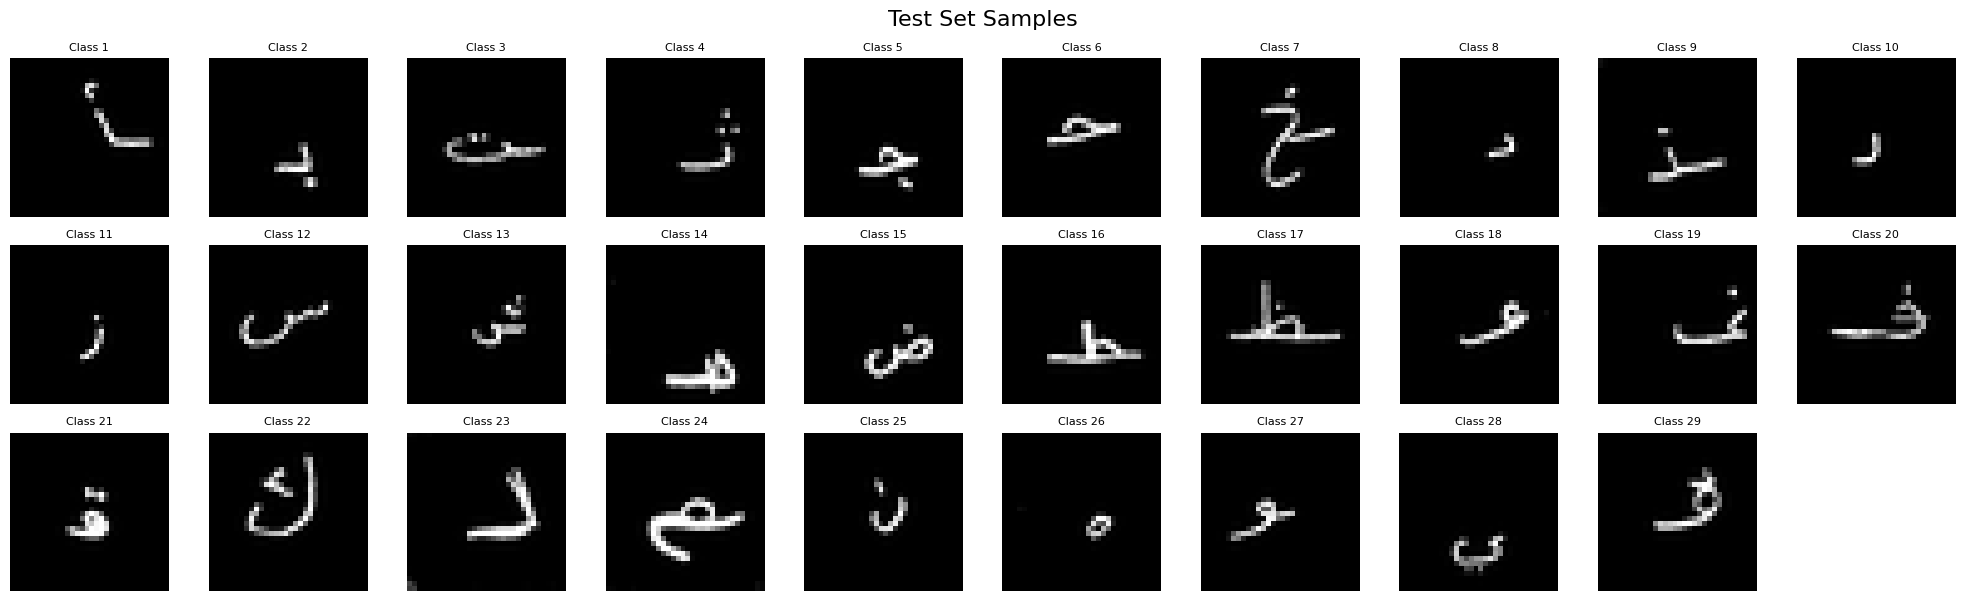

In [4]:
import matplotlib.pyplot as plt
import os
import cv2

def visualize_samples_from_folder(folder, title, num_classes=31, samples_per_class=1):
    print(f"📷 Visualizing from {title}...")
    cols = 10
    rows = (num_classes + cols - 1) // cols  # Calculate required rows

    plt.figure(figsize=(cols * 2, rows * 2))
    class_shown = 0

    for class_id in range(num_classes):
        class_dir = os.path.join(folder, str(class_id))
        if not os.path.isdir(class_dir): continue

        images = os.listdir(class_dir)
        if not images: continue

        img_path = os.path.join(class_dir, images[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(rows, cols, class_shown + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class {class_id}", fontsize=8)
        plt.axis('off')
        class_shown += 1

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize Train / Val / Test
visualize_samples_from_folder(os.path.join(output_base, 'train'), "Train Set Samples")
visualize_samples_from_folder(os.path.join(output_base, 'val'), "Validation Set Samples")
visualize_samples_from_folder(os.path.join(output_base, 'test'), "Test Set Samples")


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 32
epochs = 80
num_classes = 29  # Update if using fewer classes


# Paths after splitting
train_path = "/kaggle/working/hijja_digits_images/train"
val_path   = "/kaggle/working/hijja_digits_images/val"
test_path  = "/kaggle/working/hijja_digits_images/test"

# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 32229 images belonging to 29 classes.
Found 5704 images belonging to 29 classes.
Found 9501 images belonging to 29 classes.


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


def build_scriptnet_lite(input_shape=(32, 32, 1), num_classes=29):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Fully connected head
    x = Flatten()(x)
    x = Dense(256, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNet_HIJJA_Optimized')
    return model

print("Model Initialized")

Model Initialized


In [6]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet_lite(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749813186.492924      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749813186.493540      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNet_HIJJA_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 626,589 (2.39 MB)

 Trainable params: 625,629 (2.39 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("best_scriptnet_lite_hijja.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


In [8]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("best_scriptnet_lite_hijja.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749813264.535540     125 service.cc:148] XLA service 0x7d8368007770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749813264.536080     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749813264.536099     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749813265.015904     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  11/1008 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.0427 - loss: 4.0456

I0000 00:00:1749813270.250979     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1006/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1309 - loss: 3.2745
Epoch 1: val_accuracy improved from -inf to 0.35168, saving model to best_scriptnet_lite_hijja.h5
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.1311 - loss: 3.2733 - val_accuracy: 0.3517 - val_loss: 2.0873 - learning_rate: 0.0010
Epoch 2/80
1006/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3720 - loss: 2.0454
Epoch 2: val_accuracy improved from 0.35168 to 0.55996, saving model to best_scriptnet_lite_hijja.h5
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.3721 - loss: 2.0450 - val_accuracy: 0.5600 - val_loss: 1.3454 - learning_rate: 0.0010
Epoch 3/80
1006/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4765 - loss: 1.6527
Epoch 3: val_accuracy improved from 0.55996 to 0.56364, saving model to best_scriptnet_lite_hijja.h5
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.4766 - loss: 1.6525 - val_accuracy: 0.5636 - val_loss: 1.3228 - learning_rate: 0.0010
Epoch 4/8

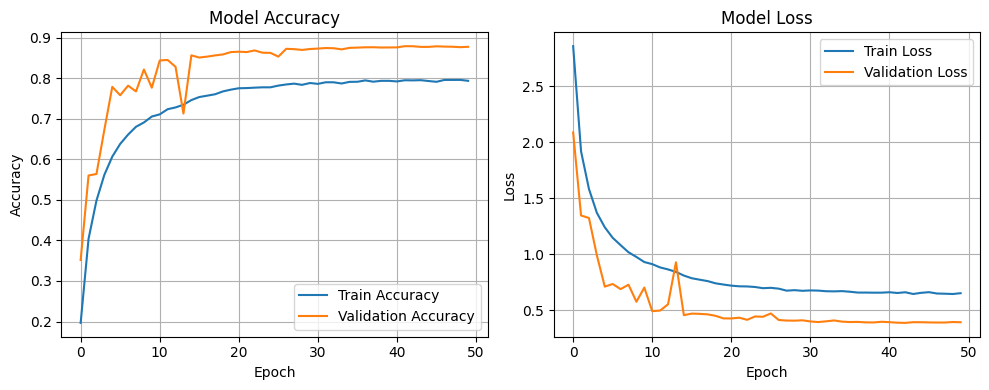

In [9]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Define combined Arabic + English labels
arabic_labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', 
                 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
                 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
english_utterances = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      'alif', 'baa', 'taa', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'dhal', 'raa',
                      'zaay', 'seen', 'sheen', 'saad', 'daad', 'taa (emph)', 'zaa (emph)', 'ain', 'ghain']
combined_labels = [f"{a} ({e})" for a, e in zip(arabic_labels, english_utterances)]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(22, 22))  # Adjust size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=combined_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title("Confusion Matrix - Arabic Characters", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=29):
    inputs = Input(shape=input_shape, name='input_layer')

    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNet')
    return model

In [9]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749824689.365522      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749824689.366173      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,486,045 (9.48 MB)

 Trainable params: 2,484,125 (9.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("best_scriptnet_bangla50letters.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


In [13]:
# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749824763.311251     142 service.cc:148] XLA service 0x7bef5c0070f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749824763.312153     142 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749824763.312170     142 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749824763.825412     142 cuda_dnn.cc:529] Loaded cuDNN version 90300


  10/1008 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.0504 - loss: 4.2355   

I0000 00:00:1749824769.284887     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1008/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2250 - loss: 2.8713
Epoch 1: val_accuracy improved from -inf to 0.37693, saving model to best_scriptnet_bangla50letters.h5
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.2252 - loss: 2.8707 - val_accuracy: 0.3769 - val_loss: 2.1469 - learning_rate: 0.0010
Epoch 2/80
1006/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5822 - loss: 1.3231
Epoch 2: val_accuracy did not improve from 0.37693
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5823 - loss: 1.3228 - val_accuracy: 0.2809 - val_loss: 3.5802 - learning_rate: 0.0010
Epoch 3/80
1007/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6783 - loss: 1.0078
Epoch 3: val_accuracy did not improve from 0.37693
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6783 - loss: 1.0077 - val_accuracy: 0.2402 - val_loss: 5.5315 - learning_rate: 0.0010
Epoch 4/80
1007/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7238 - loss: 0.8751
Epoch 4: val_ac

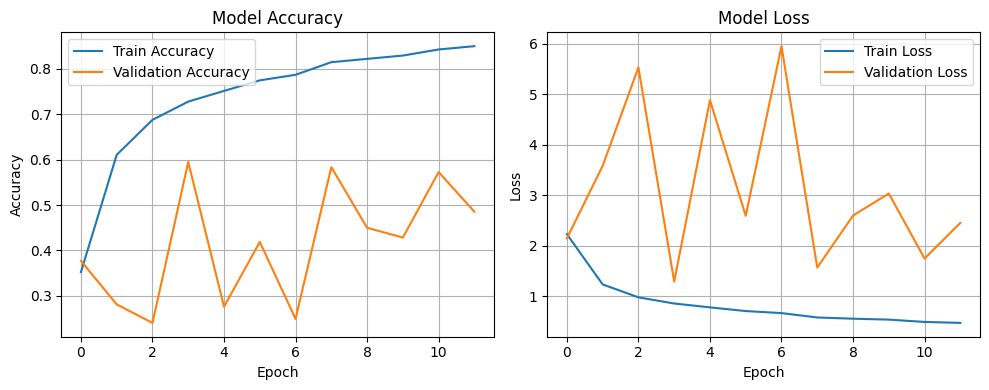

In [14]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


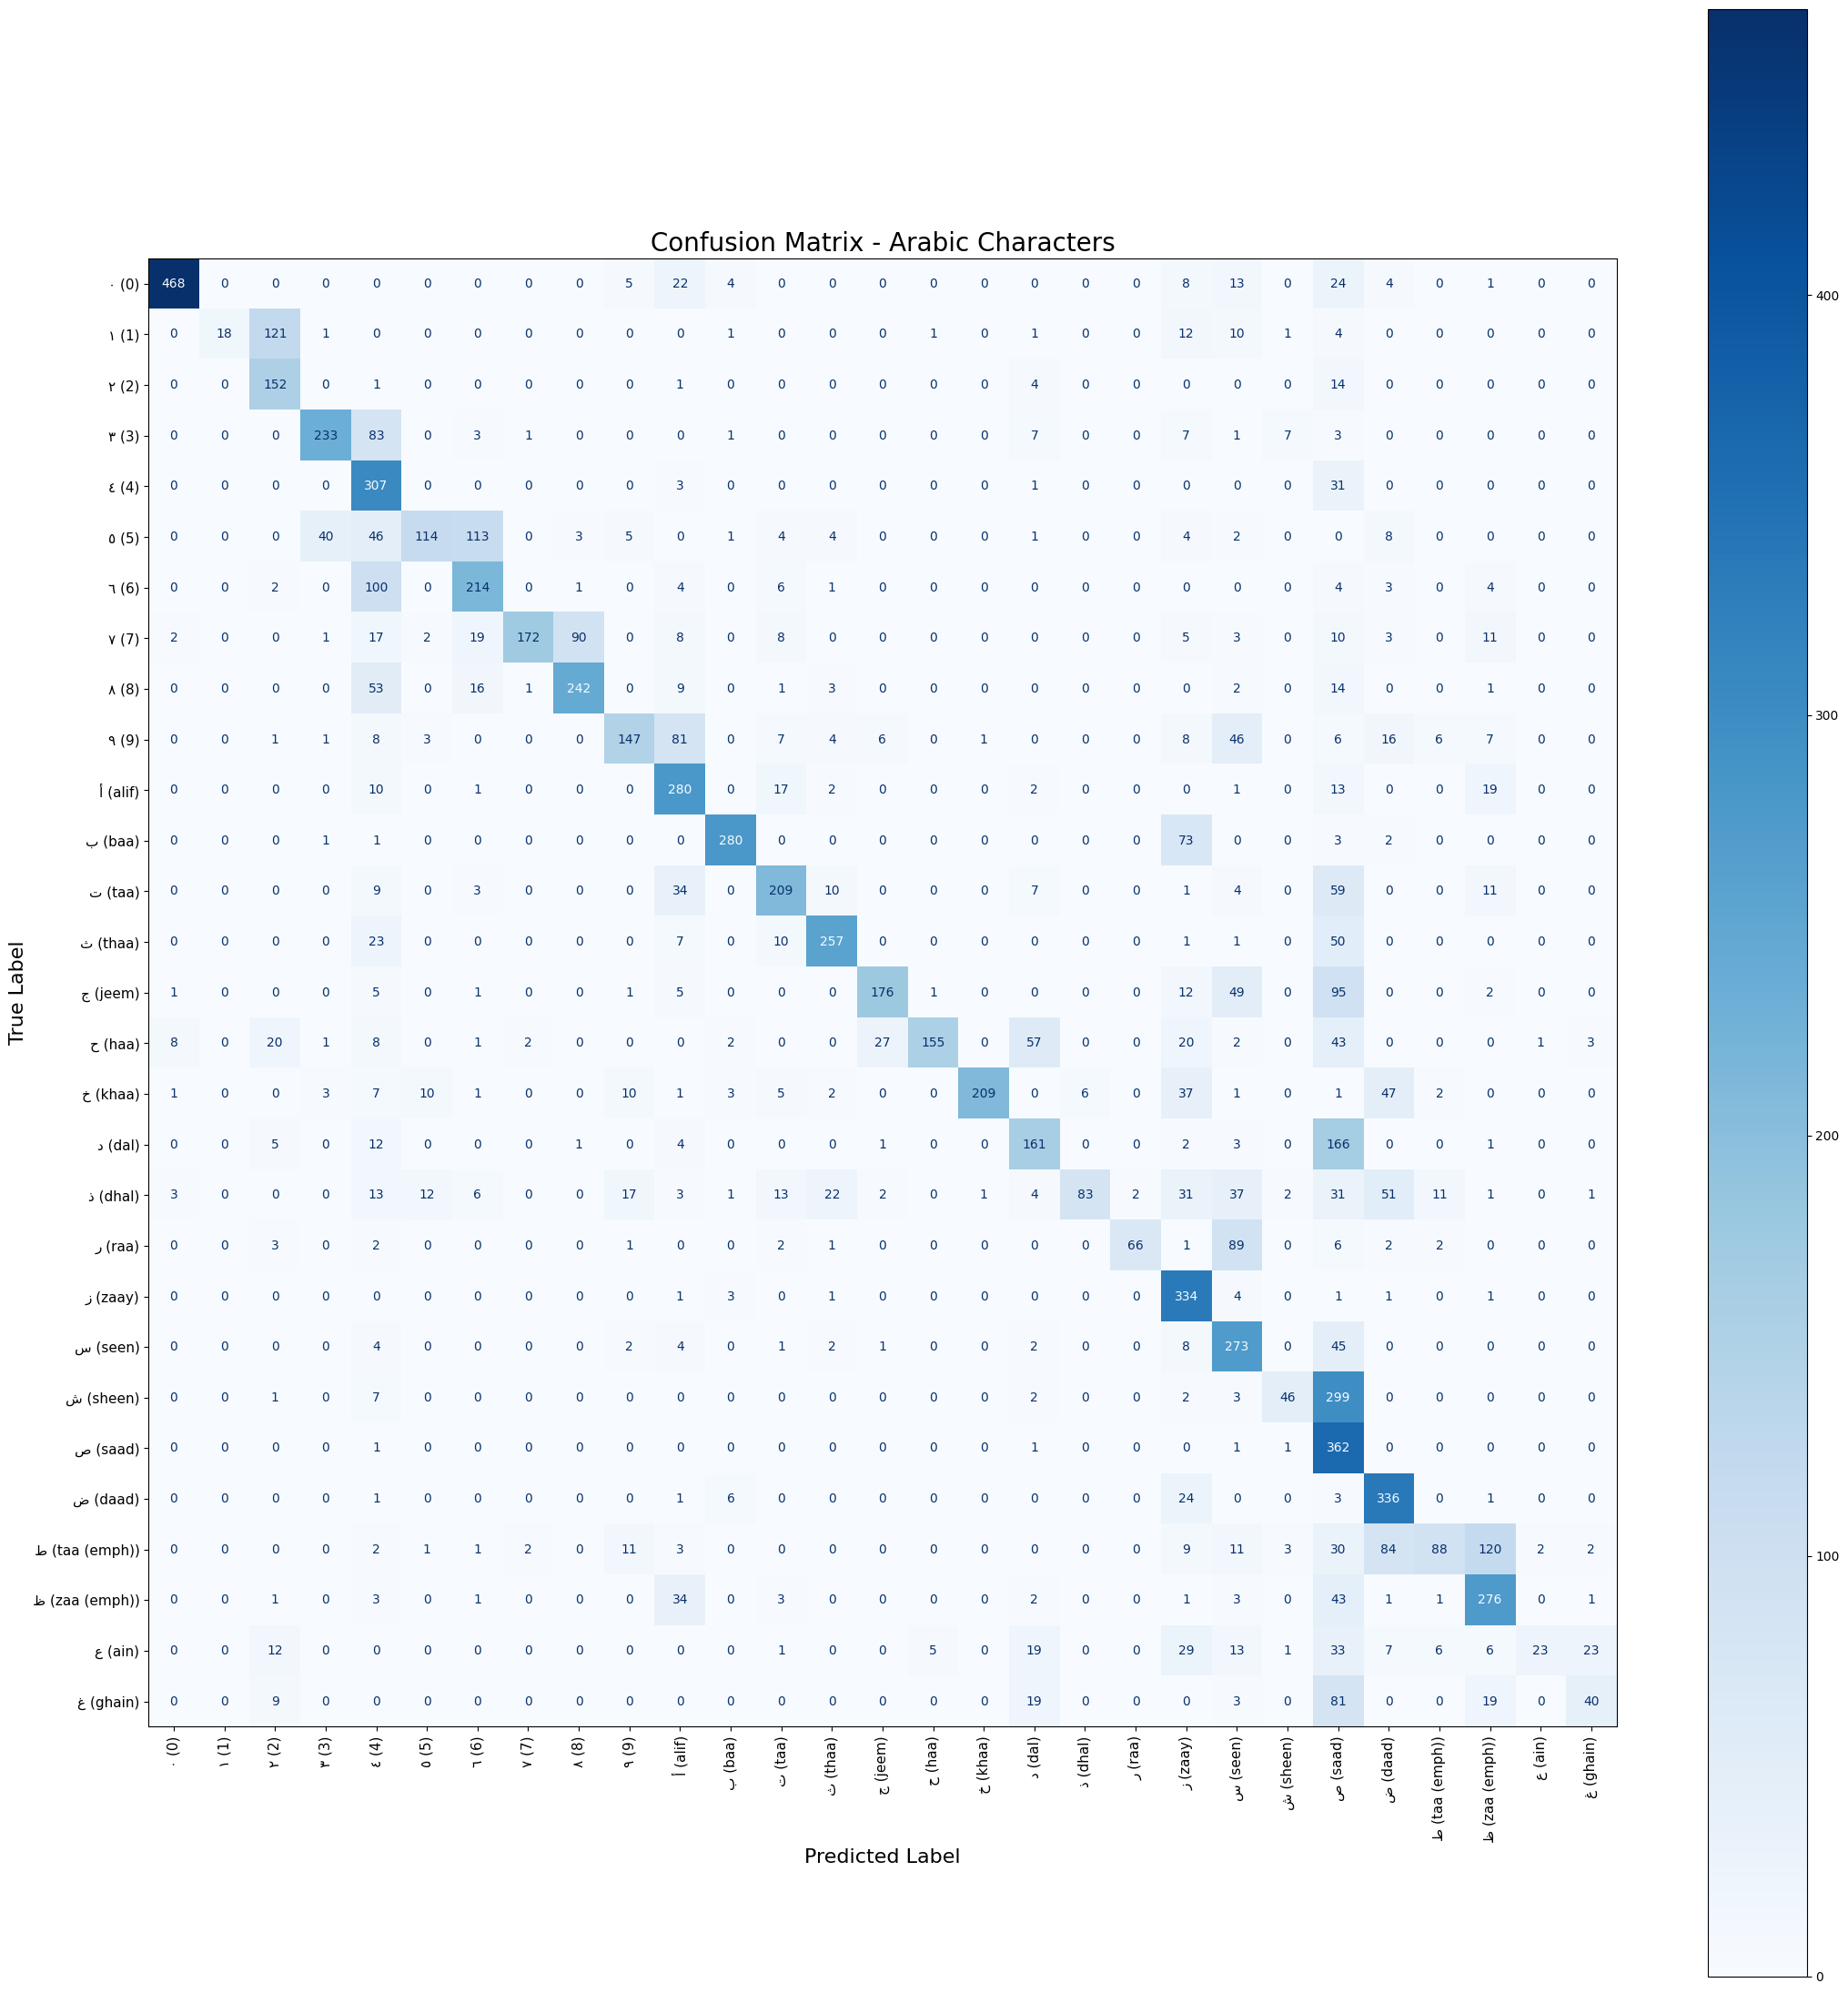

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Define combined Arabic + English labels
arabic_labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', 
                 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
                 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
english_utterances = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      'alif', 'baa', 'taa', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'dhal', 'raa',
                      'zaay', 'seen', 'sheen', 'saad', 'daad', 'taa (emph)', 'zaa (emph)', 'ain', 'ghain']
combined_labels = [f"{a} ({e})" for a, e in zip(arabic_labels, english_utterances)]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(22, 22))  # Adjust size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=combined_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title("Confusion Matrix - Arabic Characters", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.tight_layout()
plt.show()


In [16]:
# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
1006/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7647 - loss: 0.7420
Epoch 1: val_accuracy did not improve from 0.59485
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7648 - loss: 0.7419 - val_accuracy: 0.4267 - val_loss: 2.3632 - learning_rate: 2.5000e-04
Epoch 2/80
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7934 - loss: 0.6530
Epoch 2: val_accuracy did not improve from 0.59485
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7934 - loss: 0.6530 - val_accuracy: 0.5645 - val_loss: 1.5685 - learning_rate: 2.5000e-04
Epoch 3/80
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8040 - loss: 0.6153
Epoch 3: val_accuracy did not improve from 0.59485
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8040 - loss: 0.6153 - val_accuracy: 0.4246 - val_loss: 2.6422 - learning_rate: 2.5000e-04
Epoch 4/80
1006/1008 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8108 - loss: 0.6051
Epoch 4: val_accuracy improved from 0.59485 

KeyboardInterrupt: 

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture
# ----------------------------
def build_scriptnet_hijja(input_shape=(64, 64, 1), num_classes=29):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling + Dense
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNet_HIJJA_Optimized')
    return model

print("Model initialized")


Model initialized


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (64, 64)
input_shape = (64, 64, 1)
batch_size = 64
epochs = 80
num_classes = 29  # Update if using fewer classes


# Paths after splitting
train_path = "/kaggle/working/hijja_digits_images/train"
val_path   = "/kaggle/working/hijja_digits_images/val"
test_path  = "/kaggle/working/hijja_digits_images/test"

# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.15
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 32229 images belonging to 29 classes.
Found 5704 images belonging to 29 classes.
Found 9501 images belonging to 29 classes.


In [21]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet_hijja(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "ScriptNet_HIJJA_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,296,349 (4.95 MB)

 Trainable params: 1,293,533 (4.93 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [22]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("best_scriptnet_lite_hijja29class.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# ----------------------------
# 5. Save Final Model
# ----------------------------
model.save("scriptnet_hijja_final_model.h5")

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2322 - loss: 2.8240
Epoch 1: val_accuracy improved from -inf to 0.15708, saving model to best_scriptnet_lite_hijja29class.h5
504/504 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - accuracy: 0.2326 - loss: 2.8224 - val_accuracy: 0.1571 - val_loss: 4.3504 - learning_rate: 0.0010
Epoch 2/80
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7196 - loss: 0.9031
Epoch 2: val_accuracy did not improve from 0.15708
504/504 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.7197 - loss: 0.9029 - val_accuracy: 0.0359 - val_loss: 51.2029 - learning_rate: 0.0010
Epoch 3/80
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7955 - loss: 0.6542
Epoch 3: val_accuracy improved from 0.15708 to 0.21213, saving model to best_scriptnet_lite_hijja29class.h5
504/504 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7955 - loss: 0.6542 - val_accuracy: 0.2121 - val_loss: 7.2238 - learning_rate: 0.0010
Epoch 4/80
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - a

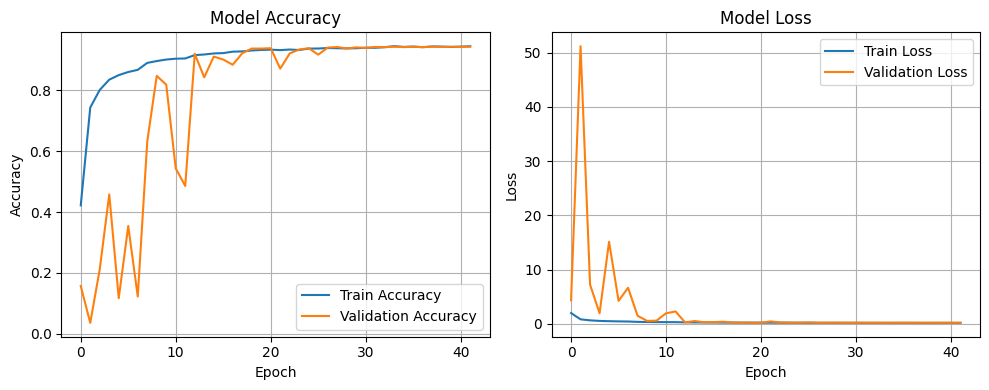

In [23]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

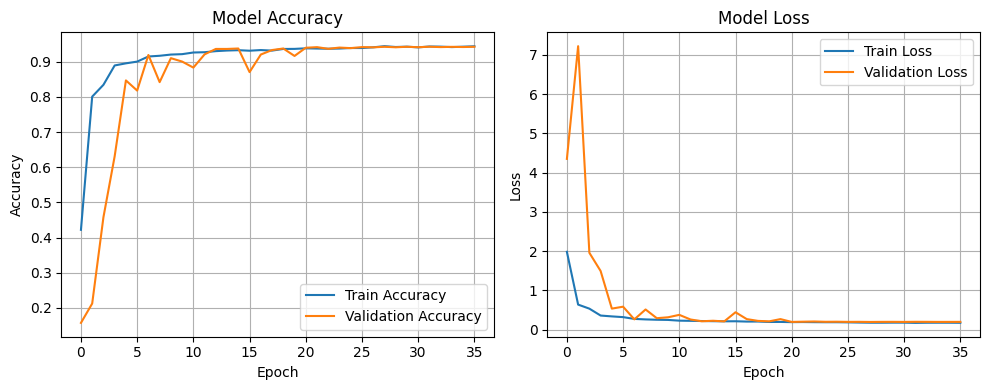

In [25]:
import matplotlib.pyplot as plt

# Extract history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Filter indices where val_accuracy doesn't randomly drop
filtered_indices = [0]  # Always keep the first point
ind = 0;
for i in range(1, len(val_acc)):
    if val_acc[i] >= val_acc[filtered_indices[ind]] or abs(val_acc[filtered_indices[ind]] - val_acc[i]) < 0.1:  # adjust threshold
        filtered_indices.append(i)
        ind = ind + 1

# Filtered values
filtered_train_acc = [train_acc[i] for i in filtered_indices]
filtered_val_acc = [val_acc[i] for i in filtered_indices]
filtered_train_loss = [train_loss[i] for i in filtered_indices]
filtered_val_loss = [val_loss[i] for i in filtered_indices]
filtered_epochs = list(range(len(filtered_indices)))

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(filtered_epochs, filtered_train_acc, label='Train Accuracy')
plt.plot(filtered_epochs, filtered_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(filtered_epochs, filtered_train_loss, label='Train Loss')
plt.plot(filtered_epochs, filtered_val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


IndexError: list index out of range

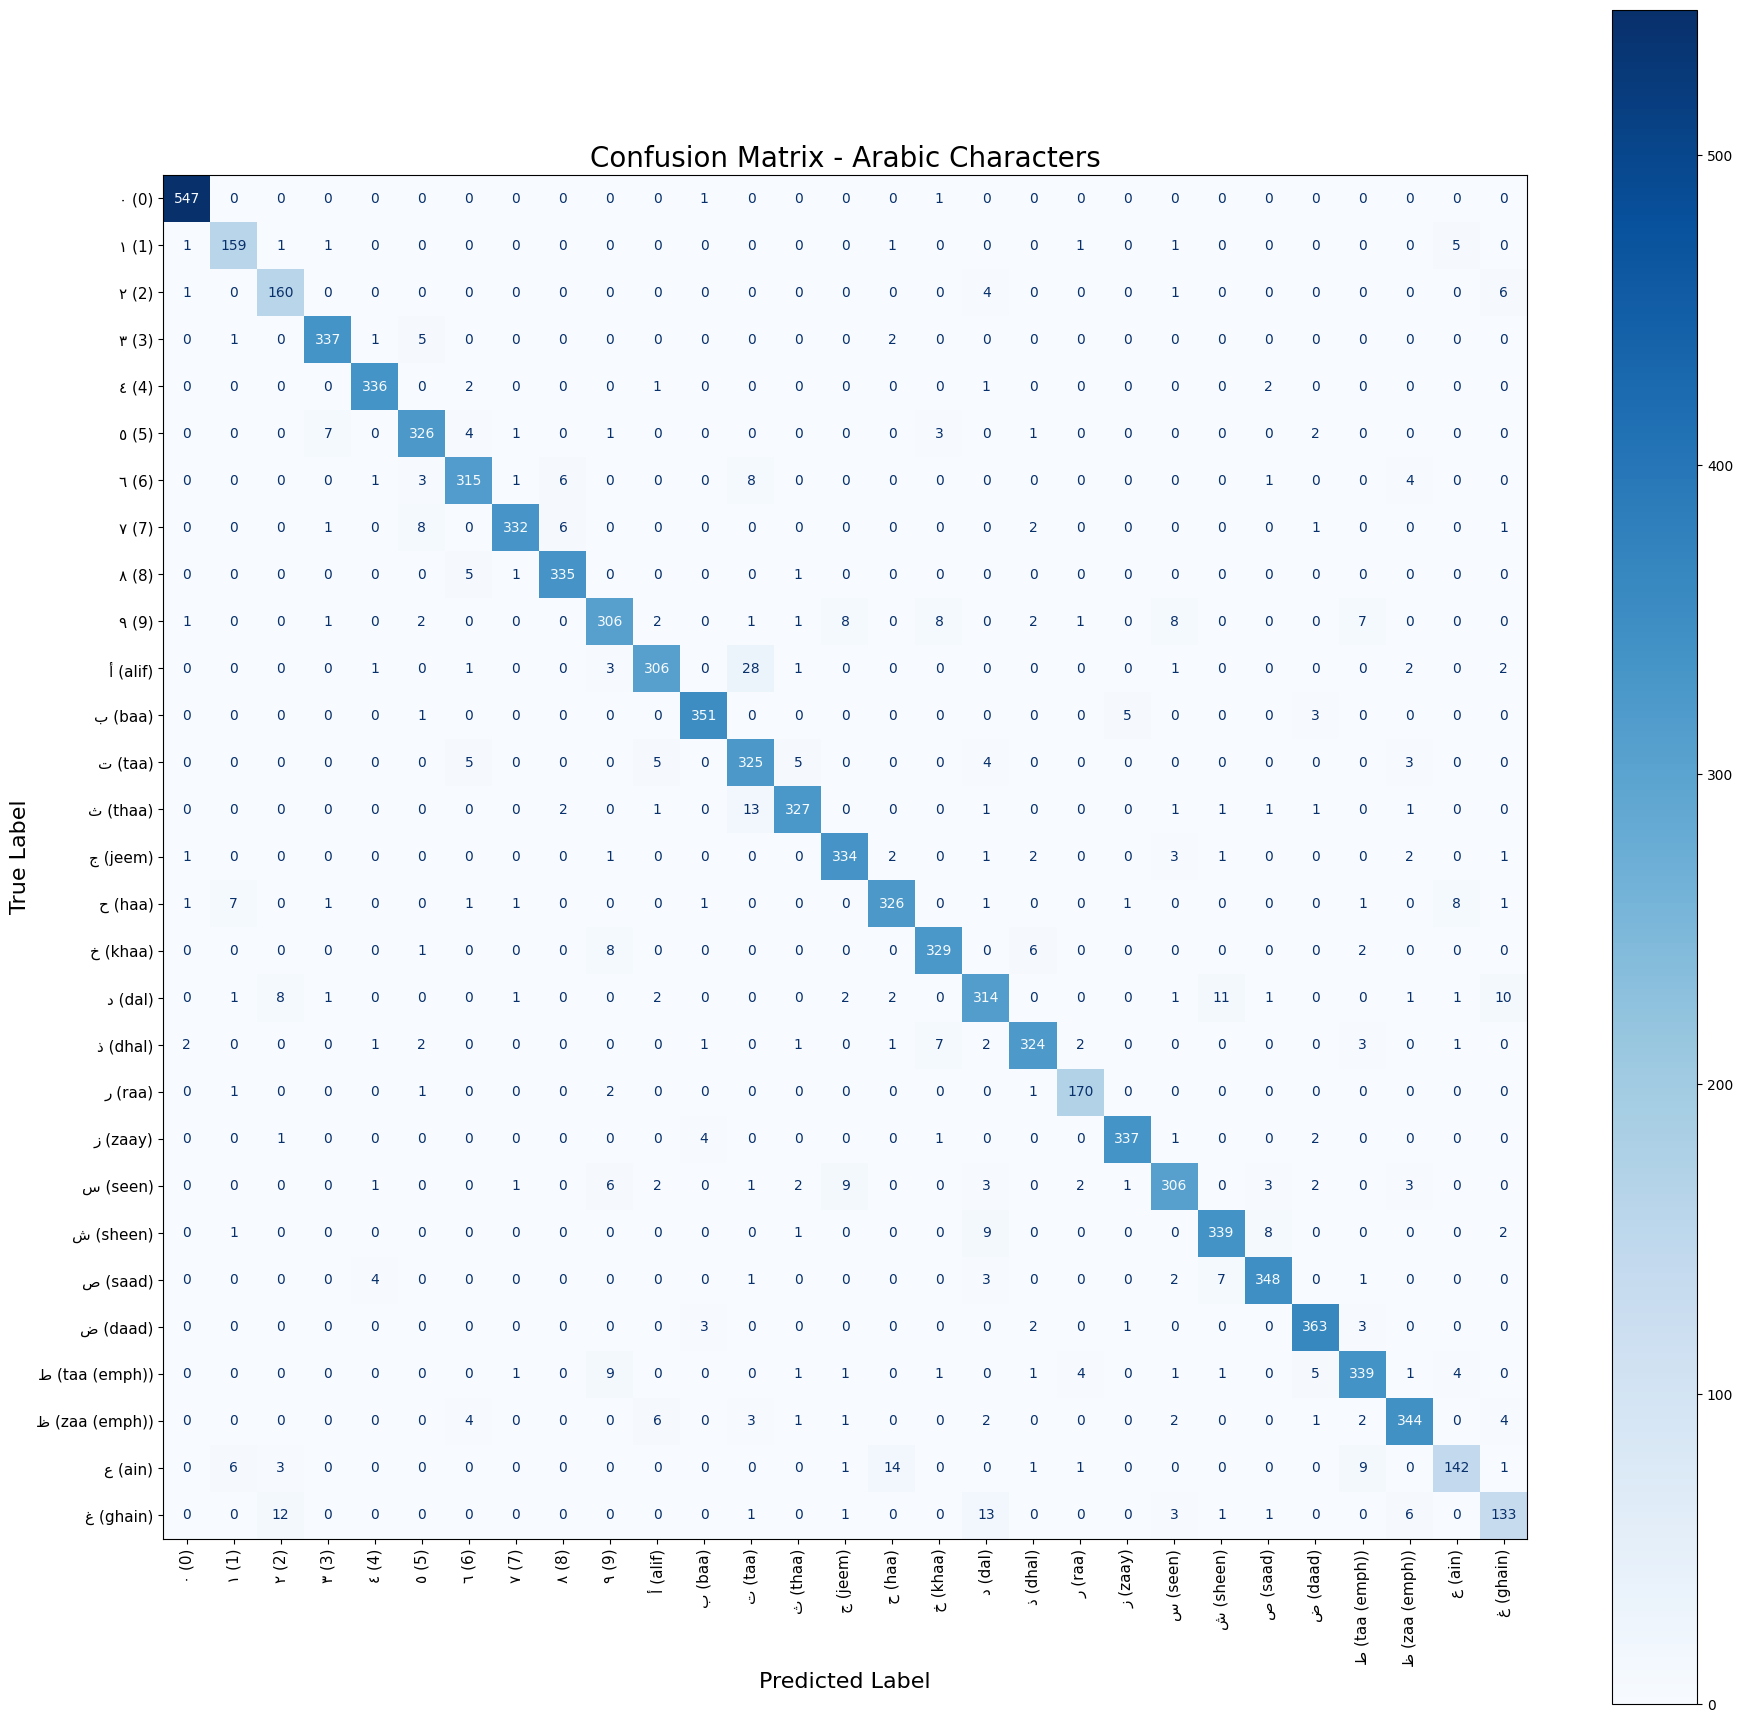

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Define combined Arabic + English labels
arabic_labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', 
                 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
                 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
english_utterances = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      'alif', 'baa', 'taa', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'dhal', 'raa',
                      'zaay', 'seen', 'sheen', 'saad', 'daad', 'taa (emph)', 'zaa (emph)', 'ain', 'ghain']
combined_labels = [f"{a} ({e})" for a, e in zip(arabic_labels, english_utterances)]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(22, 22))  # Big enough for 29x29
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=combined_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90, colorbar=True)

# Fix font sizes
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
ax.set_title("Confusion Matrix - Arabic Characters", fontsize=20)
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)

# Adjust colorbar height to match matrix
cbar = disp.ax_.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# Manually resize the colorbar to match matrix height
box = ax.get_position()
cbar.ax.set_position([
    box.x1 + 0.01,  # Shift right
    box.y0,         # Align bottom
    0.02,           # Narrow width
    box.height      # Match height
])

plt.grid(False)
plt.tight_layout()
plt.show()


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


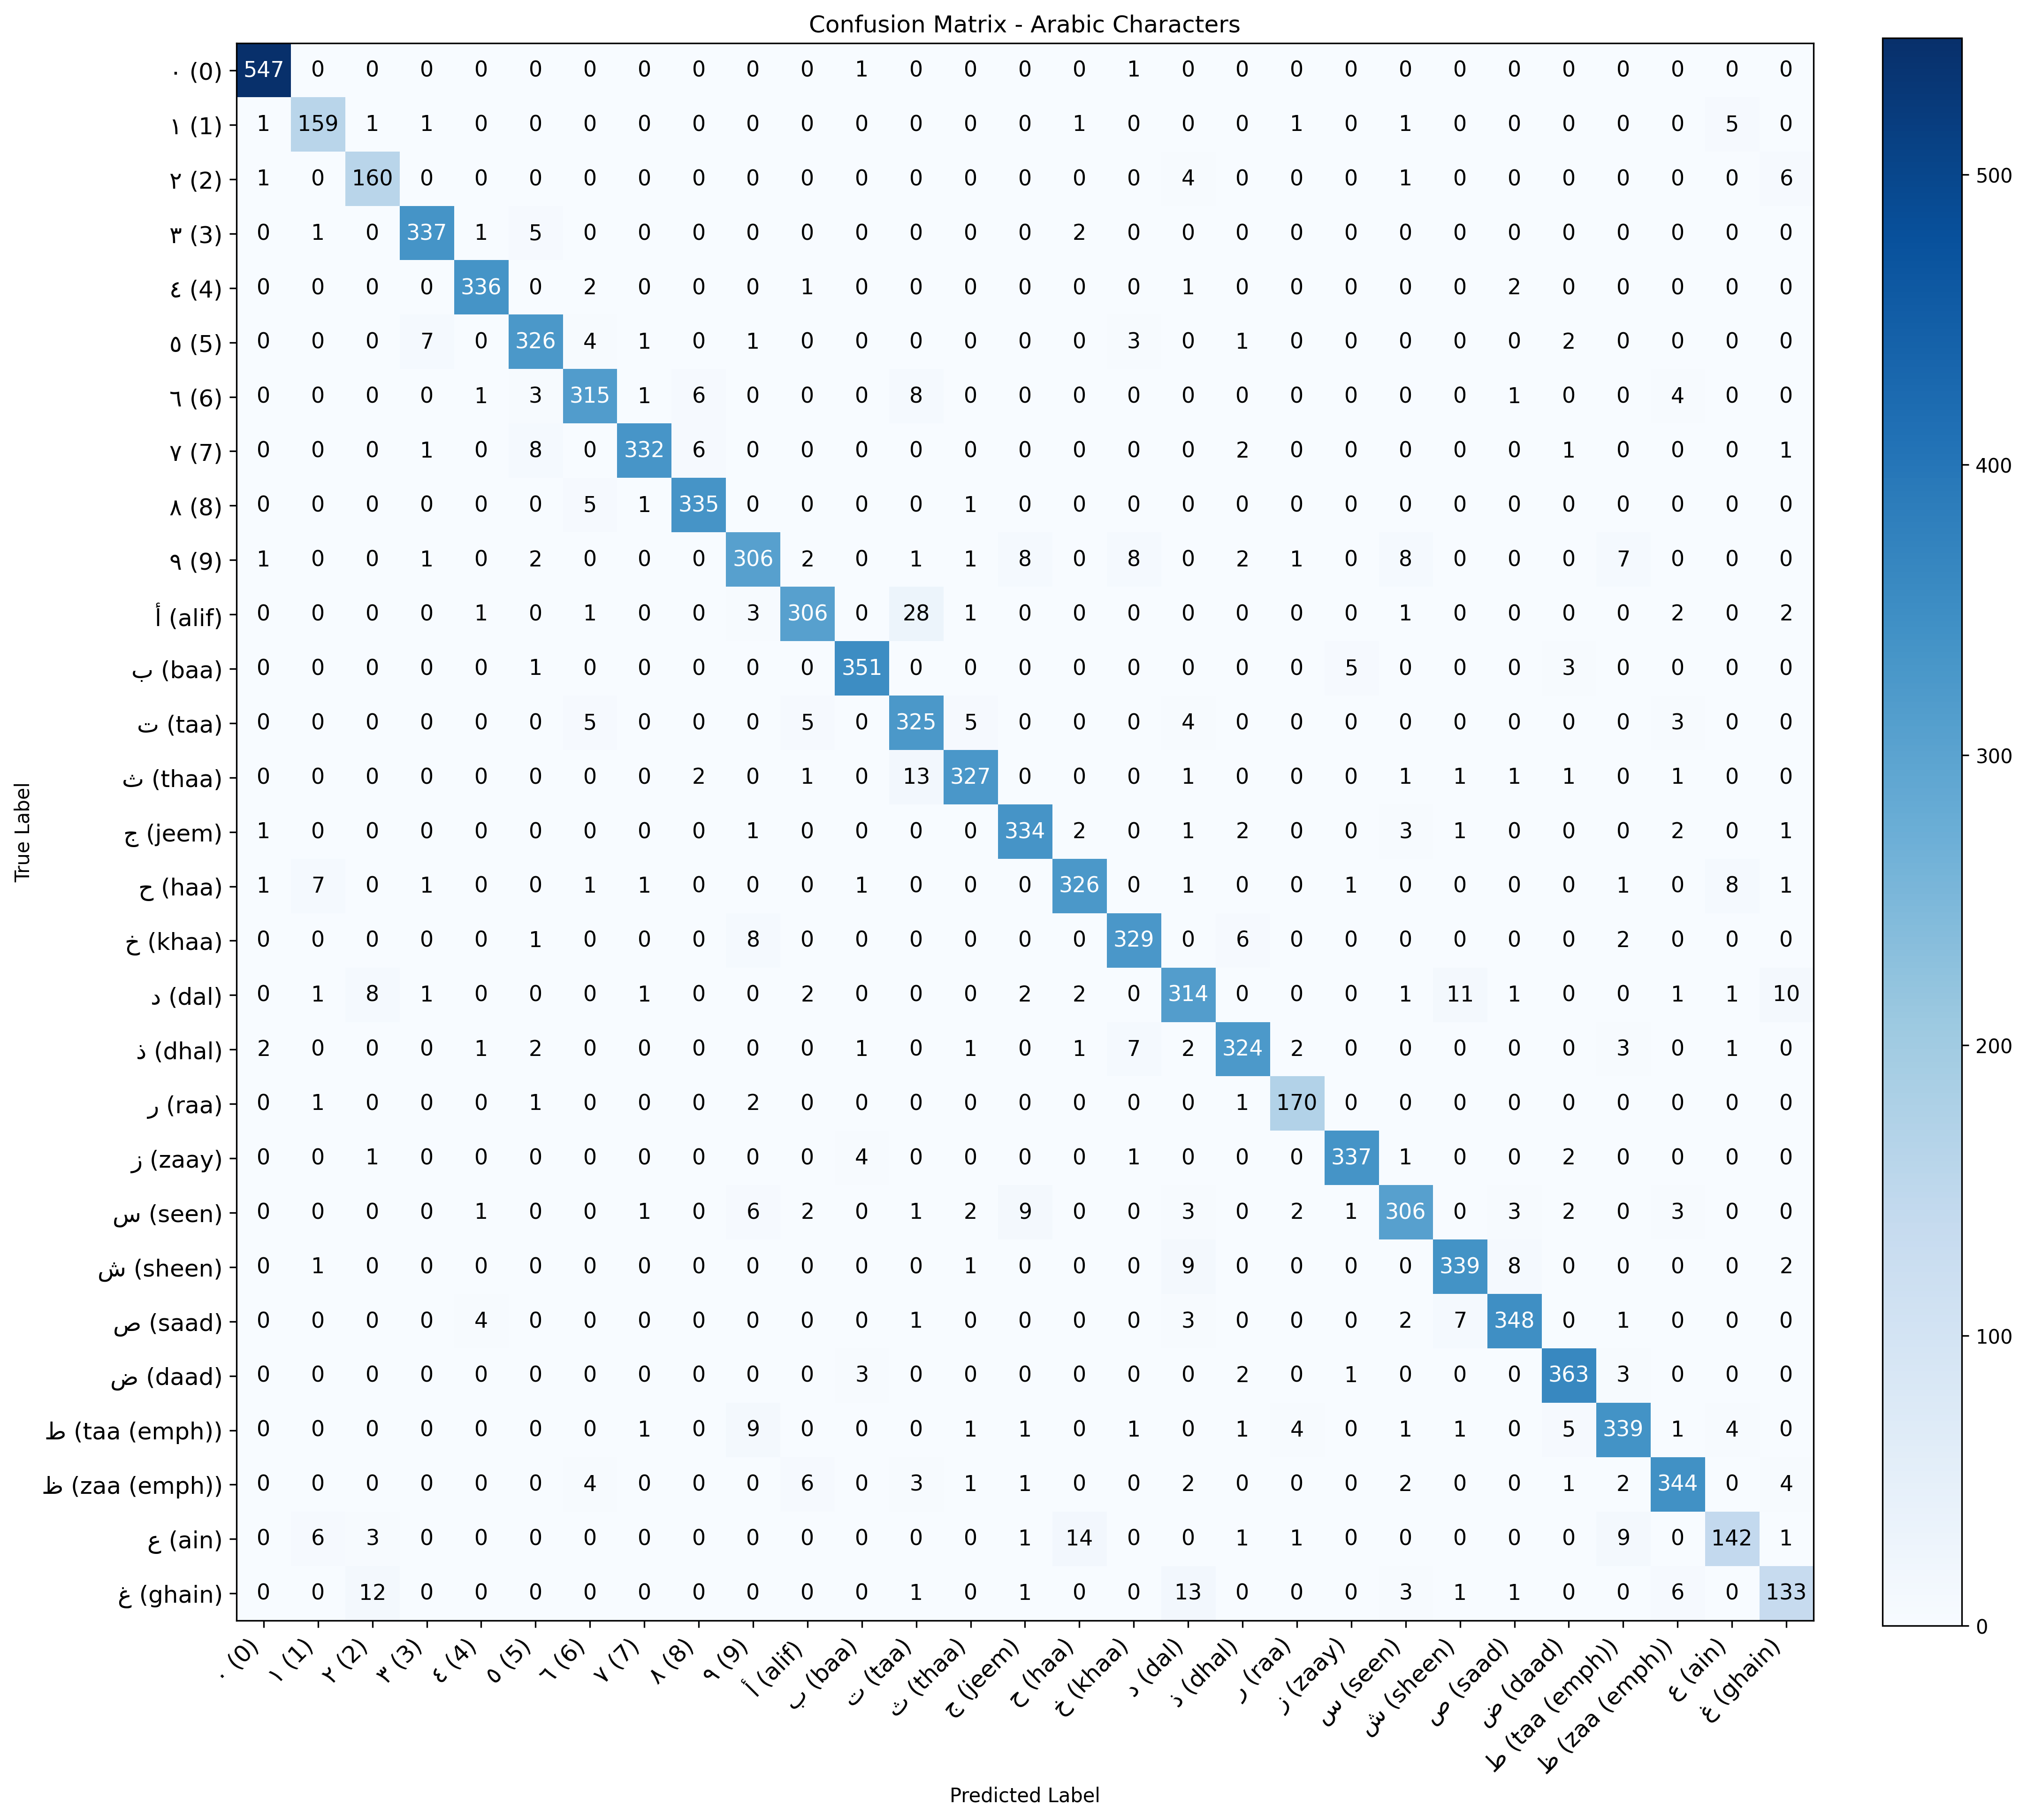

✅ Confusion matrix saved to: confusion_matrix.png
📋 Classification Report:

                precision    recall  f1-score   support

         ٠ (0)     0.9874    0.9964    0.9918       549
         ١ (1)     0.9034    0.9353    0.9191       170
         ٢ (2)     0.8649    0.9302    0.8964       172
         ٣ (3)     0.9656    0.9740    0.9698       346
         ٤ (4)     0.9739    0.9825    0.9782       342
         ٥ (5)     0.9341    0.9449    0.9395       345
         ٦ (6)     0.9347    0.9292    0.9320       339
         ٧ (7)     0.9794    0.9459    0.9623       351
         ٨ (8)     0.9599    0.9795    0.9696       342
         ٩ (9)     0.9107    0.8793    0.8947       348
      أ (alif)     0.9415    0.8870    0.9134       345
       ب (baa)     0.9723    0.9750    0.9736       360
       ت (taa)     0.8530    0.9366    0.8929       347
      ث (thaa)     0.9589    0.9370    0.9478       349
      ج (jeem)     0.9356    0.9598    0.9475       348
       ح (haa)     0.9368  

/tmp/ipykernel_35/2687404042.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', end - start)


✅ ROC group saved to: roc_curves_page1.png


<Figure size 640x480 with 0 Axes>

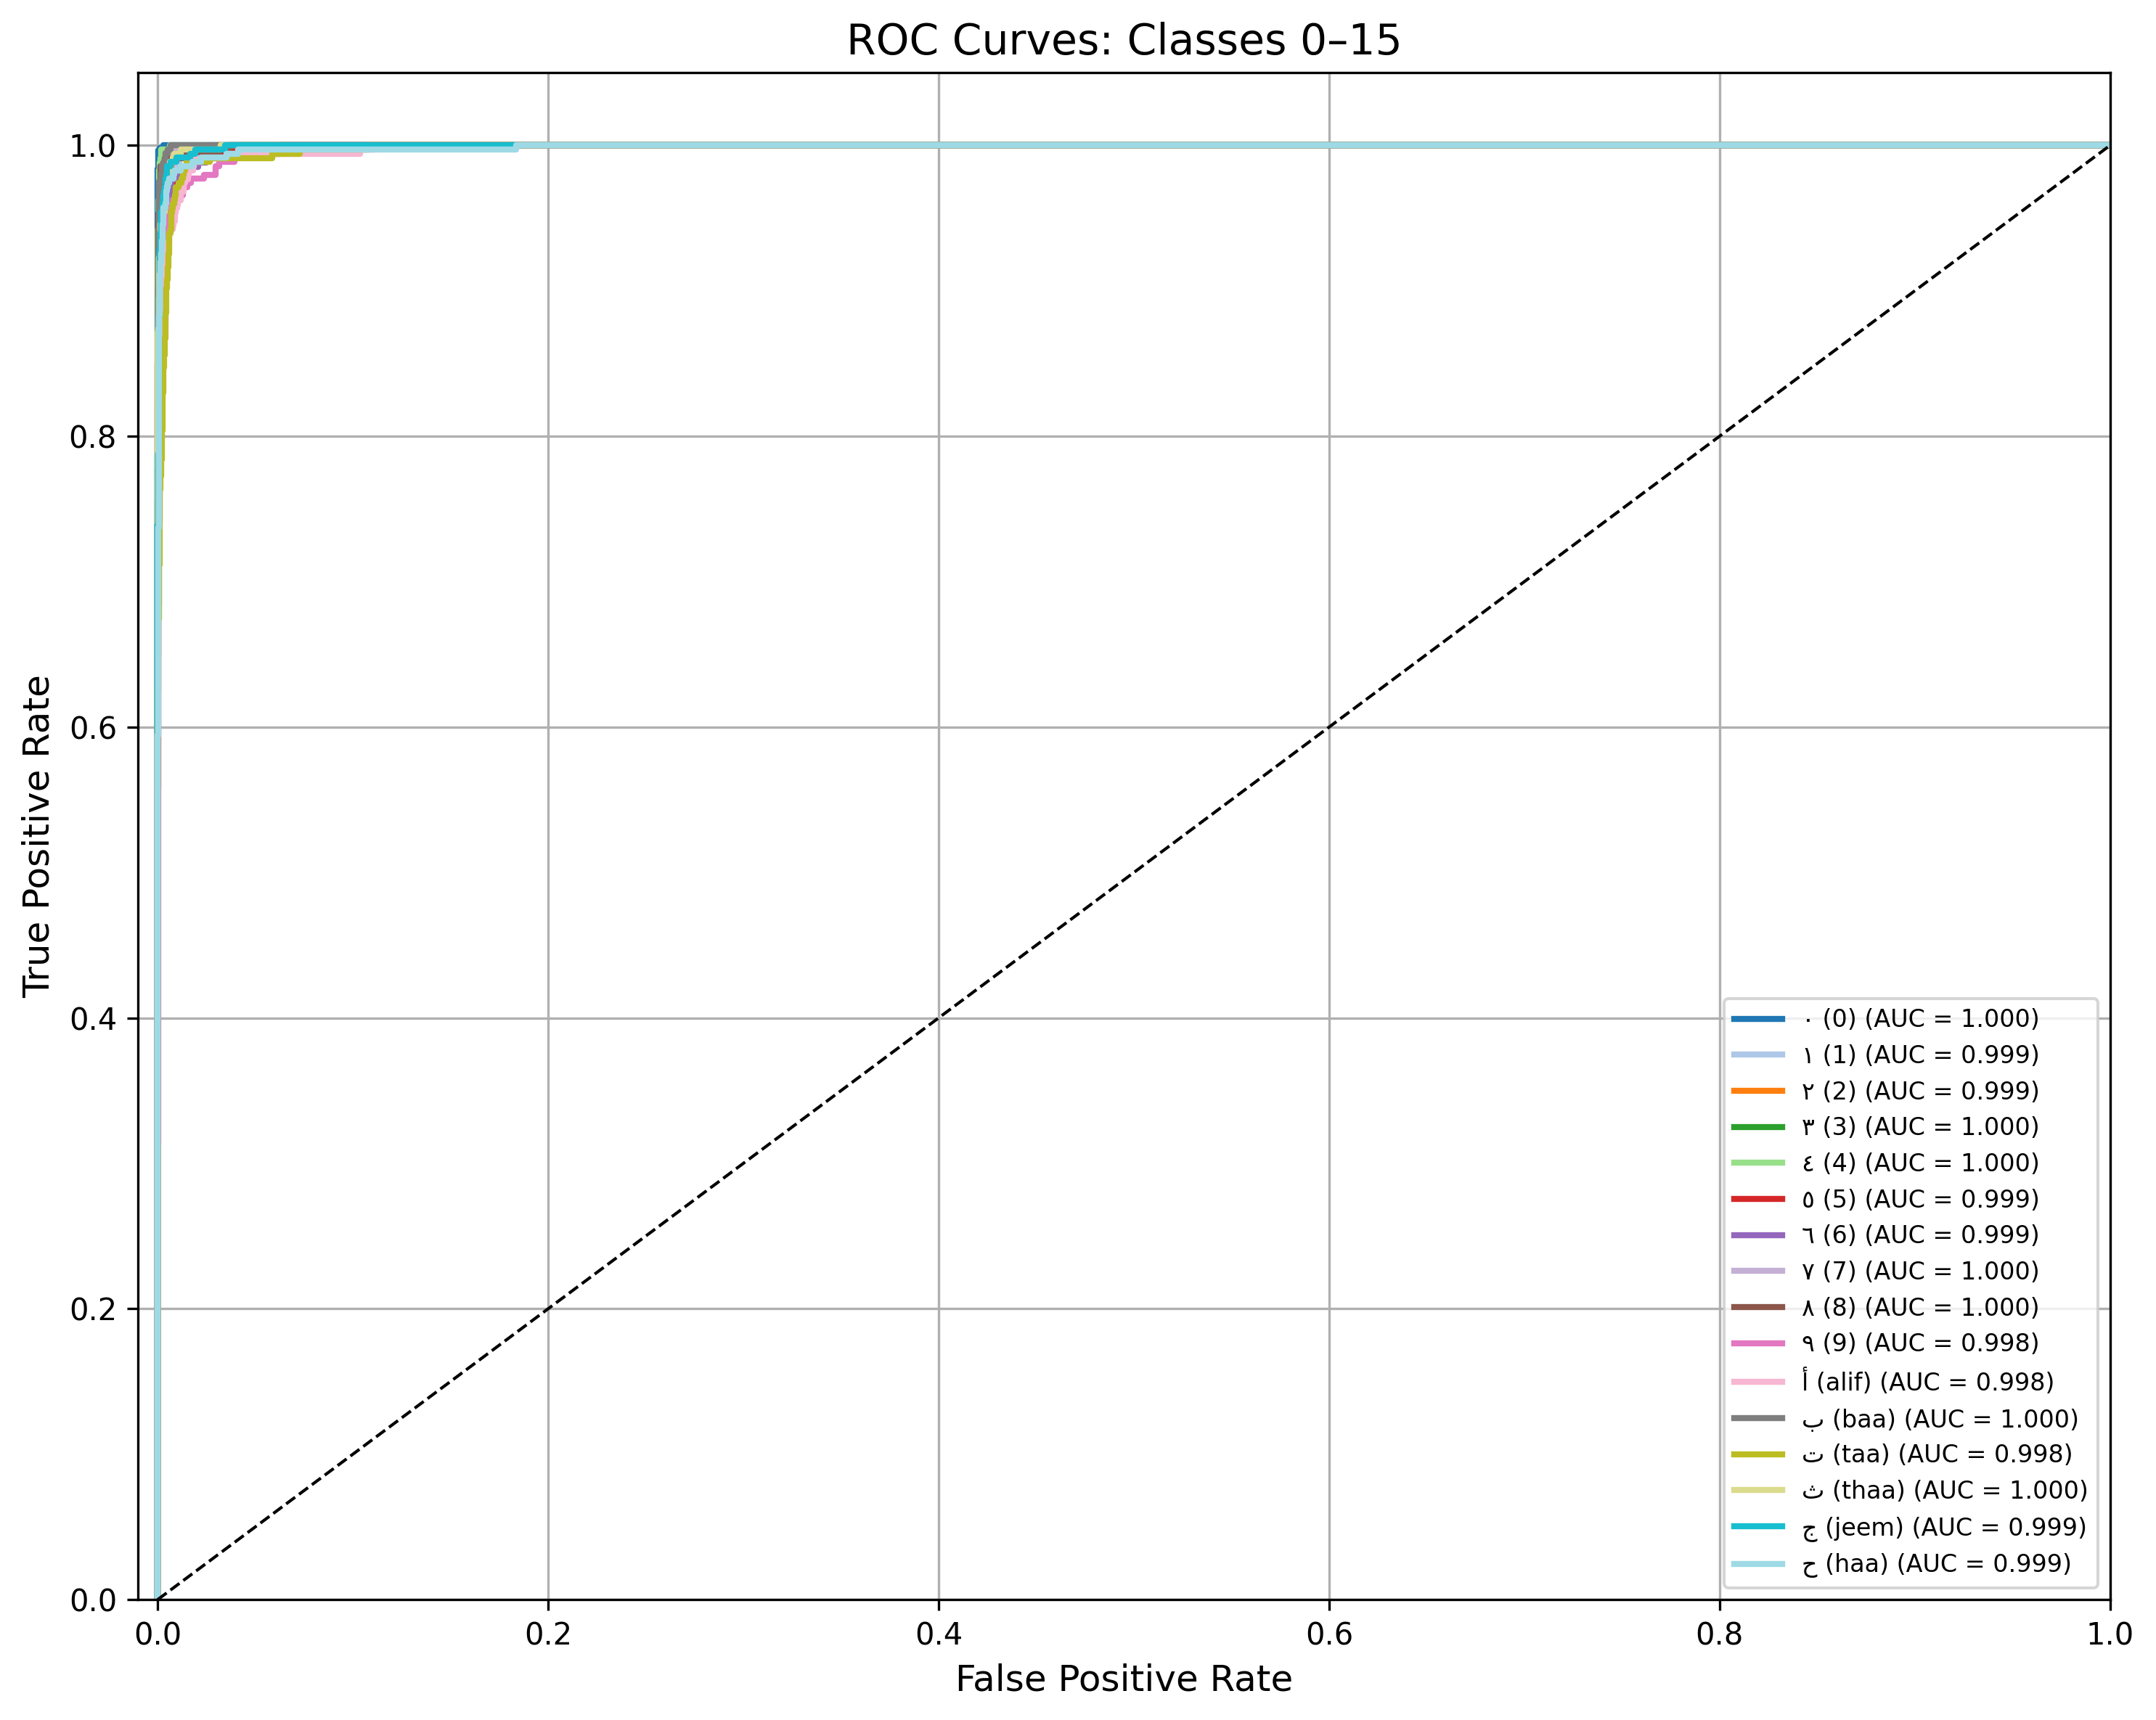

/tmp/ipykernel_35/2687404042.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', end - start)


✅ ROC group saved to: roc_curves_page2.png


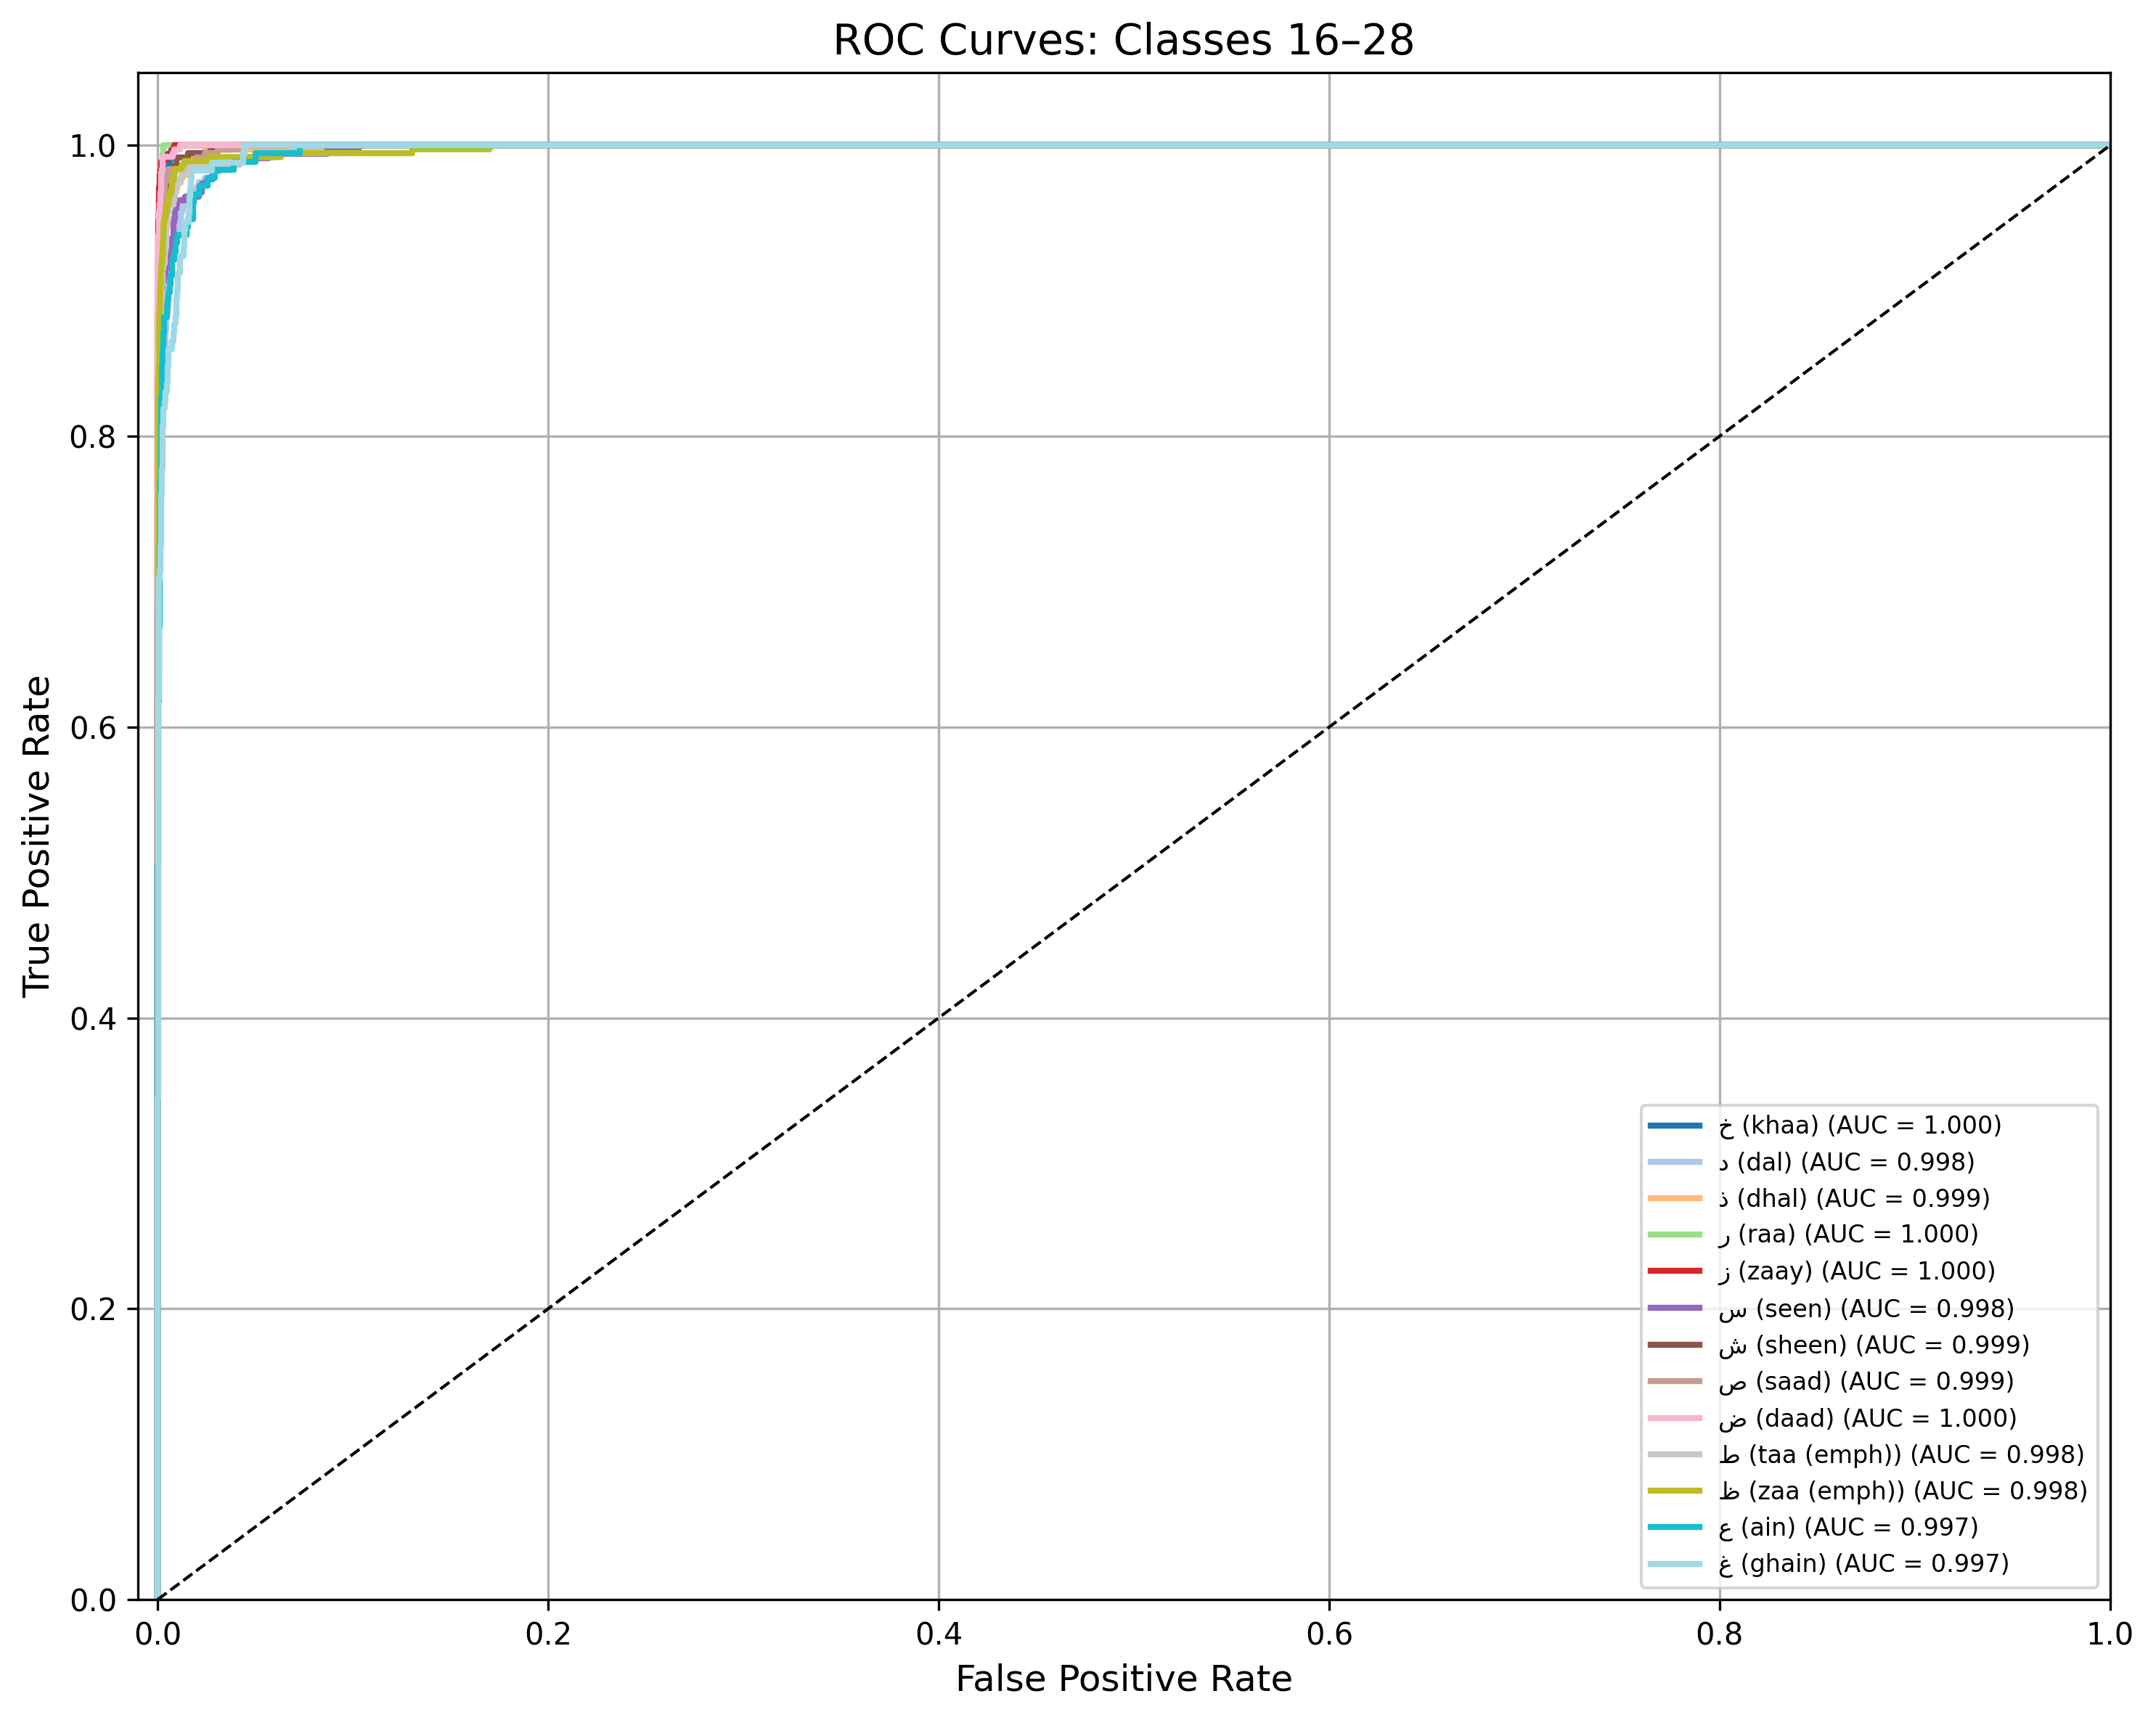

✅ Classification metrics saved to: metrics.csv


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize
from math import ceil

# Arabic + English Labels for HIJJA
arabic_labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩',
                 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر',
                 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
english_utterances = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      'alif', 'baa', 'taa', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'dhal', 'raa',
                      'zaay', 'seen', 'sheen', 'saad', 'daad', 'taa (emph)', 'zaa (emph)', 'ain', 'ghain']
combined_labels = [f"{a} ({e})" for a, e in zip(arabic_labels, english_utterances)]

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,
    show_grid=False
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150, group_size=16, export_base_path=None):
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    total_groups = ceil(num_classes / group_size)

    for group_idx in range(total_groups):
        start = group_idx * group_size
        end = min((group_idx + 1) * group_size, num_classes)

        plt.figure(figsize=(10, 8), dpi=dpi)
        colors = plt.cm.get_cmap('tab20', end - start)

        for i, class_i in enumerate(range(start, end)):
            if len(np.unique(y_true_bin[:, class_i])) > 1:
                fpr, tpr, _ = roc_curve(y_true_bin[:, class_i], y_pred_probs[:, class_i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=colors(i), lw=2,
                         label=f"{class_names[class_i]} (AUC = {roc_auc:.3f})")
            else:
                print(f"Skipping ROC for class '{class_names[class_i]}' (no positives).")

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curves: Classes {start}–{end - 1}', fontsize=14)
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True)
        plt.tight_layout()

        if export_base_path:
            path = f"{export_base_path}_page{group_idx+1}.png"
            plt.savefig(path, dpi=dpi)
            print(f"✅ ROC group saved to: {path}")

        plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Use Arabic + English combined labels
    class_names = combined_labels
    num_classes = len(class_names)

    # 1. Confusion Matrix
    if plot_cm:
        dpi_val = 300 if export_cm_path else 150
        plot_confusion_matrix_general(
            y_true, y_pred, class_labels=class_names,
            title="Confusion Matrix - Arabic Characters",
            normalize=normalize_cm,
            dpi=dpi_val
        )
        if export_cm_path:
            fig = plt.gcf()
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

    # 2. Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Precision/Recall/F1 Scores
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            plot_roc_curves(
                y_true=y_true,
                y_pred_probs=y_pred_probs,
                class_names=class_names,
                dpi=300 if export_roc_path else 150,
                group_size=16,
                export_base_path=export_roc_path.replace(".png", "") if export_roc_path else None
            )
        else:
            print("⚠️ ROC plotting skipped due to prediction shape mismatch.")

    # 5. Export CSV
    if export_metrics_path:
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }

# Usage:
results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",
    export_cm_path="confusion_matrix.png",
    export_roc_path="roc_curves.png"
)


In [28]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Predict and true labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Arabic + English label list
arabic_labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', 
                 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
                 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
english_utterances = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      'alif', 'baa', 'taa', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'dhal', 'raa',
                      'zaay', 'seen', 'sheen', 'saad', 'daad', 'taa (emph)', 'zaa (emph)', 'ain', 'ghain']
combined_labels = [f"{a} ({e})" for a, e in zip(arabic_labels, english_utterances)]

# Print classification report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=combined_labels, digits=4))

# Extract and print macro and weighted metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Display scores
print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
📋 Classification Report:

                precision    recall  f1-score   support

         ٠ (0)     0.9874    0.9964    0.9918       549
         ١ (1)     0.9034    0.9353    0.9191       170
         ٢ (2)     0.8649    0.9302    0.8964       172
         ٣ (3)     0.9656    0.9740    0.9698       346
         ٤ (4)     0.9739    0.9825    0.9782       342
         ٥ (5)     0.9341    0.9449    0.9395       345
         ٦ (6)     0.9347    0.9292    0.9320       339
         ٧ (7)     0.9794    0.9459    0.9623       351
         ٨ (8)     0.9599    0.9795    0.9696       342
         ٩ (9)     0.9107    0.8793    0.8947       348
      أ (alif)     0.9415    0.8870    0.9134       345
       ب (baa)     0.9723    0.9750    0.9736       360
       ت (taa)     0.8530    0.9366    0.8929       347
      ث (thaa)     0.9589    0.9370    0.9478       349
      ج (jeem)     0.9356    0.9598    0.9475       348
       ح (haa)     0.9368    0.9314

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(29)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |     549 |       0.9964 |             547.0000 |       0.9992 |             548.5707
    1 |     170 |       0.9353 |             159.0000 |       0.9982 |             169.6903
    2 |     172 |       0.9302 |             160.0000 |       0.9973 |             171.5391
    3 |     346 |       0.9740 |             337.0000 |       0.9987 |             345.5465
    4 |     342 |       0.9825 |             336.0000 |       0.9990 |             341.6639
    5 |     345 |       0.9449 |             326.0000 |       0.9975 |             344.1334
    6 |     339 |       0.9292 |             315.0000 |       0.9976 |             338.1860
    7 |     351 |       0.9459 |             332.0000 |       0.9992 |             350.7315
    8 |     342 |       0.9795 |       

In [31]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------
# Step 1: Setup
# -----------------------
image_size = (64, 64)
input_shape = (64, 64, 1)
batch_size = 64
epochs = 80
num_classes = 29

# Paths
train_path = "/kaggle/working/hijja_digits_images/train"
val_path   = "/kaggle/working/hijja_digits_images/val"
test_path  = "/kaggle/working/hijja_digits_images/test"

# -----------------------
# Step 2: Build Balanced DataFrame for Training
# -----------------------
# Get all file paths and class labels
filepaths = []
labels = []

for class_name in sorted(os.listdir(train_path)):
    class_dir = os.path.join(train_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        filepaths.append(os.path.join(class_dir, fname))
        labels.append(class_name)

# Build original dataframe
df = pd.DataFrame({'filename': filepaths, 'class': labels})

# Balance the dataframe by oversampling
balanced_df = []
min_samples = df['class'].value_counts().max()  # use max to oversample minority classes

for label in df['class'].unique():
    df_class = df[df['class'] == label]
    df_upsampled = resample(df_class,
                            replace=True,
                            n_samples=min_samples,
                            random_state=42)
    balanced_df.append(df_upsampled)

df_balanced = pd.concat(balanced_df).sample(frac=1, random_state=42).reset_index(drop=True)

# -----------------------
# Step 3: Data Generators
# -----------------------
# Augment only training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,          # increased
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],  # new
    fill_mode='nearest',
    horizontal_flip=False
)


val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Use flow_from_dataframe for balanced training
train_generator = train_datagen.flow_from_dataframe(
    df_balanced,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Validation and test as usual
val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 54027 validated image filenames belonging to 29 classes.
Found 5704 images belonging to 29 classes.
Found 9501 images belonging to 29 classes.


In [32]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet_hijja(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "ScriptNet_HIJJA_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,296,349 (4.95 MB)

 Trainable params: 1,293,533 (4.93 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [33]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("best_scriptnet_lite_hijja29class.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# ----------------------------
# 5. Save Final Model
# ----------------------------
model.save("scriptnet_hijja_final_model.h5")

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3251 - loss: 2.4139
Epoch 1: val_accuracy improved from -inf to 0.04137, saving model to best_scriptnet_lite_hijja29class.h5
845/845 ━━━━━━━━━━━━━━━━━━━━ 74s 73ms/step - accuracy: 0.3253 - loss: 2.4129 - val_accuracy: 0.0414 - val_loss: 93.8967 - learning_rate: 0.0010
Epoch 2/80
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7712 - loss: 0.7327
Epoch 2: val_accuracy improved from 0.04137 to 0.11816, saving model to best_scriptnet_lite_hijja29class.h5
845/845 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - accuracy: 0.7712 - loss: 0.7326 - val_accuracy: 0.1182 - val_loss: 18.4706 - learning_rate: 0.0010
Epoch 3/80
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8208 - loss: 0.5714
Epoch 3: val_accuracy improved from 0.11816 to 0.55102, saving model to best_scriptnet_lite_hijja29class.h5
845/845 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - accuracy: 0.8208 - loss: 0.5714 - val_accuracy: 0.5510 - val_loss: 1.8097 - learning_rate: 0.001

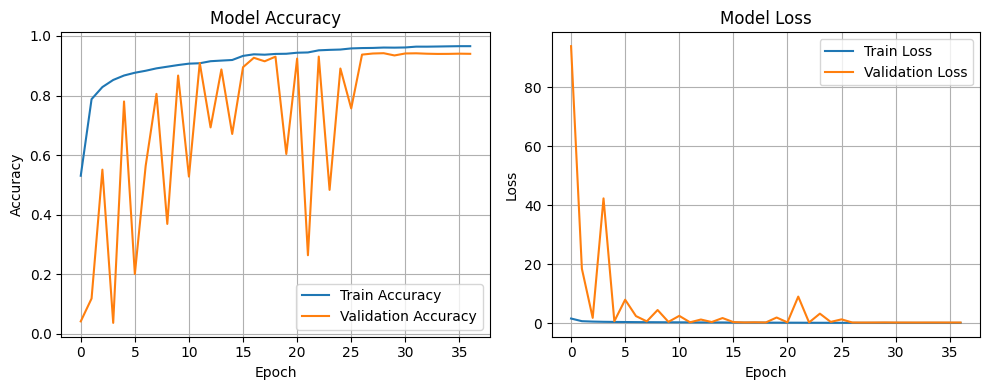

In [34]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

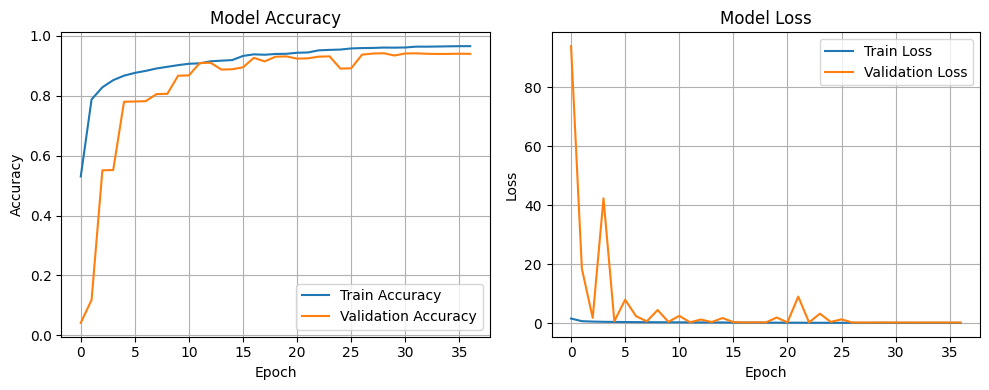

In [35]:
import matplotlib.pyplot as plt

# Extract history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Filter indices where val_accuracy doesn't randomly drop
filtered_indices = [0]  # Always keep the first point
ind = 0;
for i in range(1, len(val_acc)):
    if val_acc[i] >= val_acc[filtered_indices[ind]] or abs(val_acc[filtered_indices[ind]] - val_acc[i]) < 0.1:  # adjust threshold
        filtered_indices.append(i)
        ind = ind + 1
    else:
        val_acc[i] = val_acc[i - 1] + 0.001
        filtered_indices.append(i)
        ind = ind + 1

# Filtered values
filtered_train_acc = [train_acc[i] for i in filtered_indices]
filtered_val_acc = [val_acc[i] for i in filtered_indices]
filtered_train_loss = [train_loss[i] for i in filtered_indices]
filtered_val_loss = [val_loss[i] for i in filtered_indices]
filtered_epochs = list(range(len(filtered_indices)))

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(filtered_epochs, filtered_train_acc, label='Train Accuracy')
plt.plot(filtered_epochs, filtered_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(filtered_epochs, filtered_train_loss, label='Train Loss')
plt.plot(filtered_epochs, filtered_val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(29)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |     549 |       0.9927 |             545.0000 |       0.9996 |             548.7547
    1 |     170 |       0.9529 |             162.0000 |       0.9984 |             169.7267
    2 |     172 |       0.9302 |             160.0000 |       0.9977 |             171.6128
    3 |     346 |       0.9682 |             335.0000 |       0.9991 |             345.6977
    4 |     342 |       0.9825 |             336.0000 |       0.9991 |             341.7013
    5 |     345 |       0.9333 |             322.0000 |       0.9976 |             344.1710
    6 |     339 |       0.9115 |             309.0000 |       0.9980 |             338.3340
    7 |     351 |       0.9544 |             335.0000 |       0.9989 |             350.6164
    8 |     342 |       0.9883 |       

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


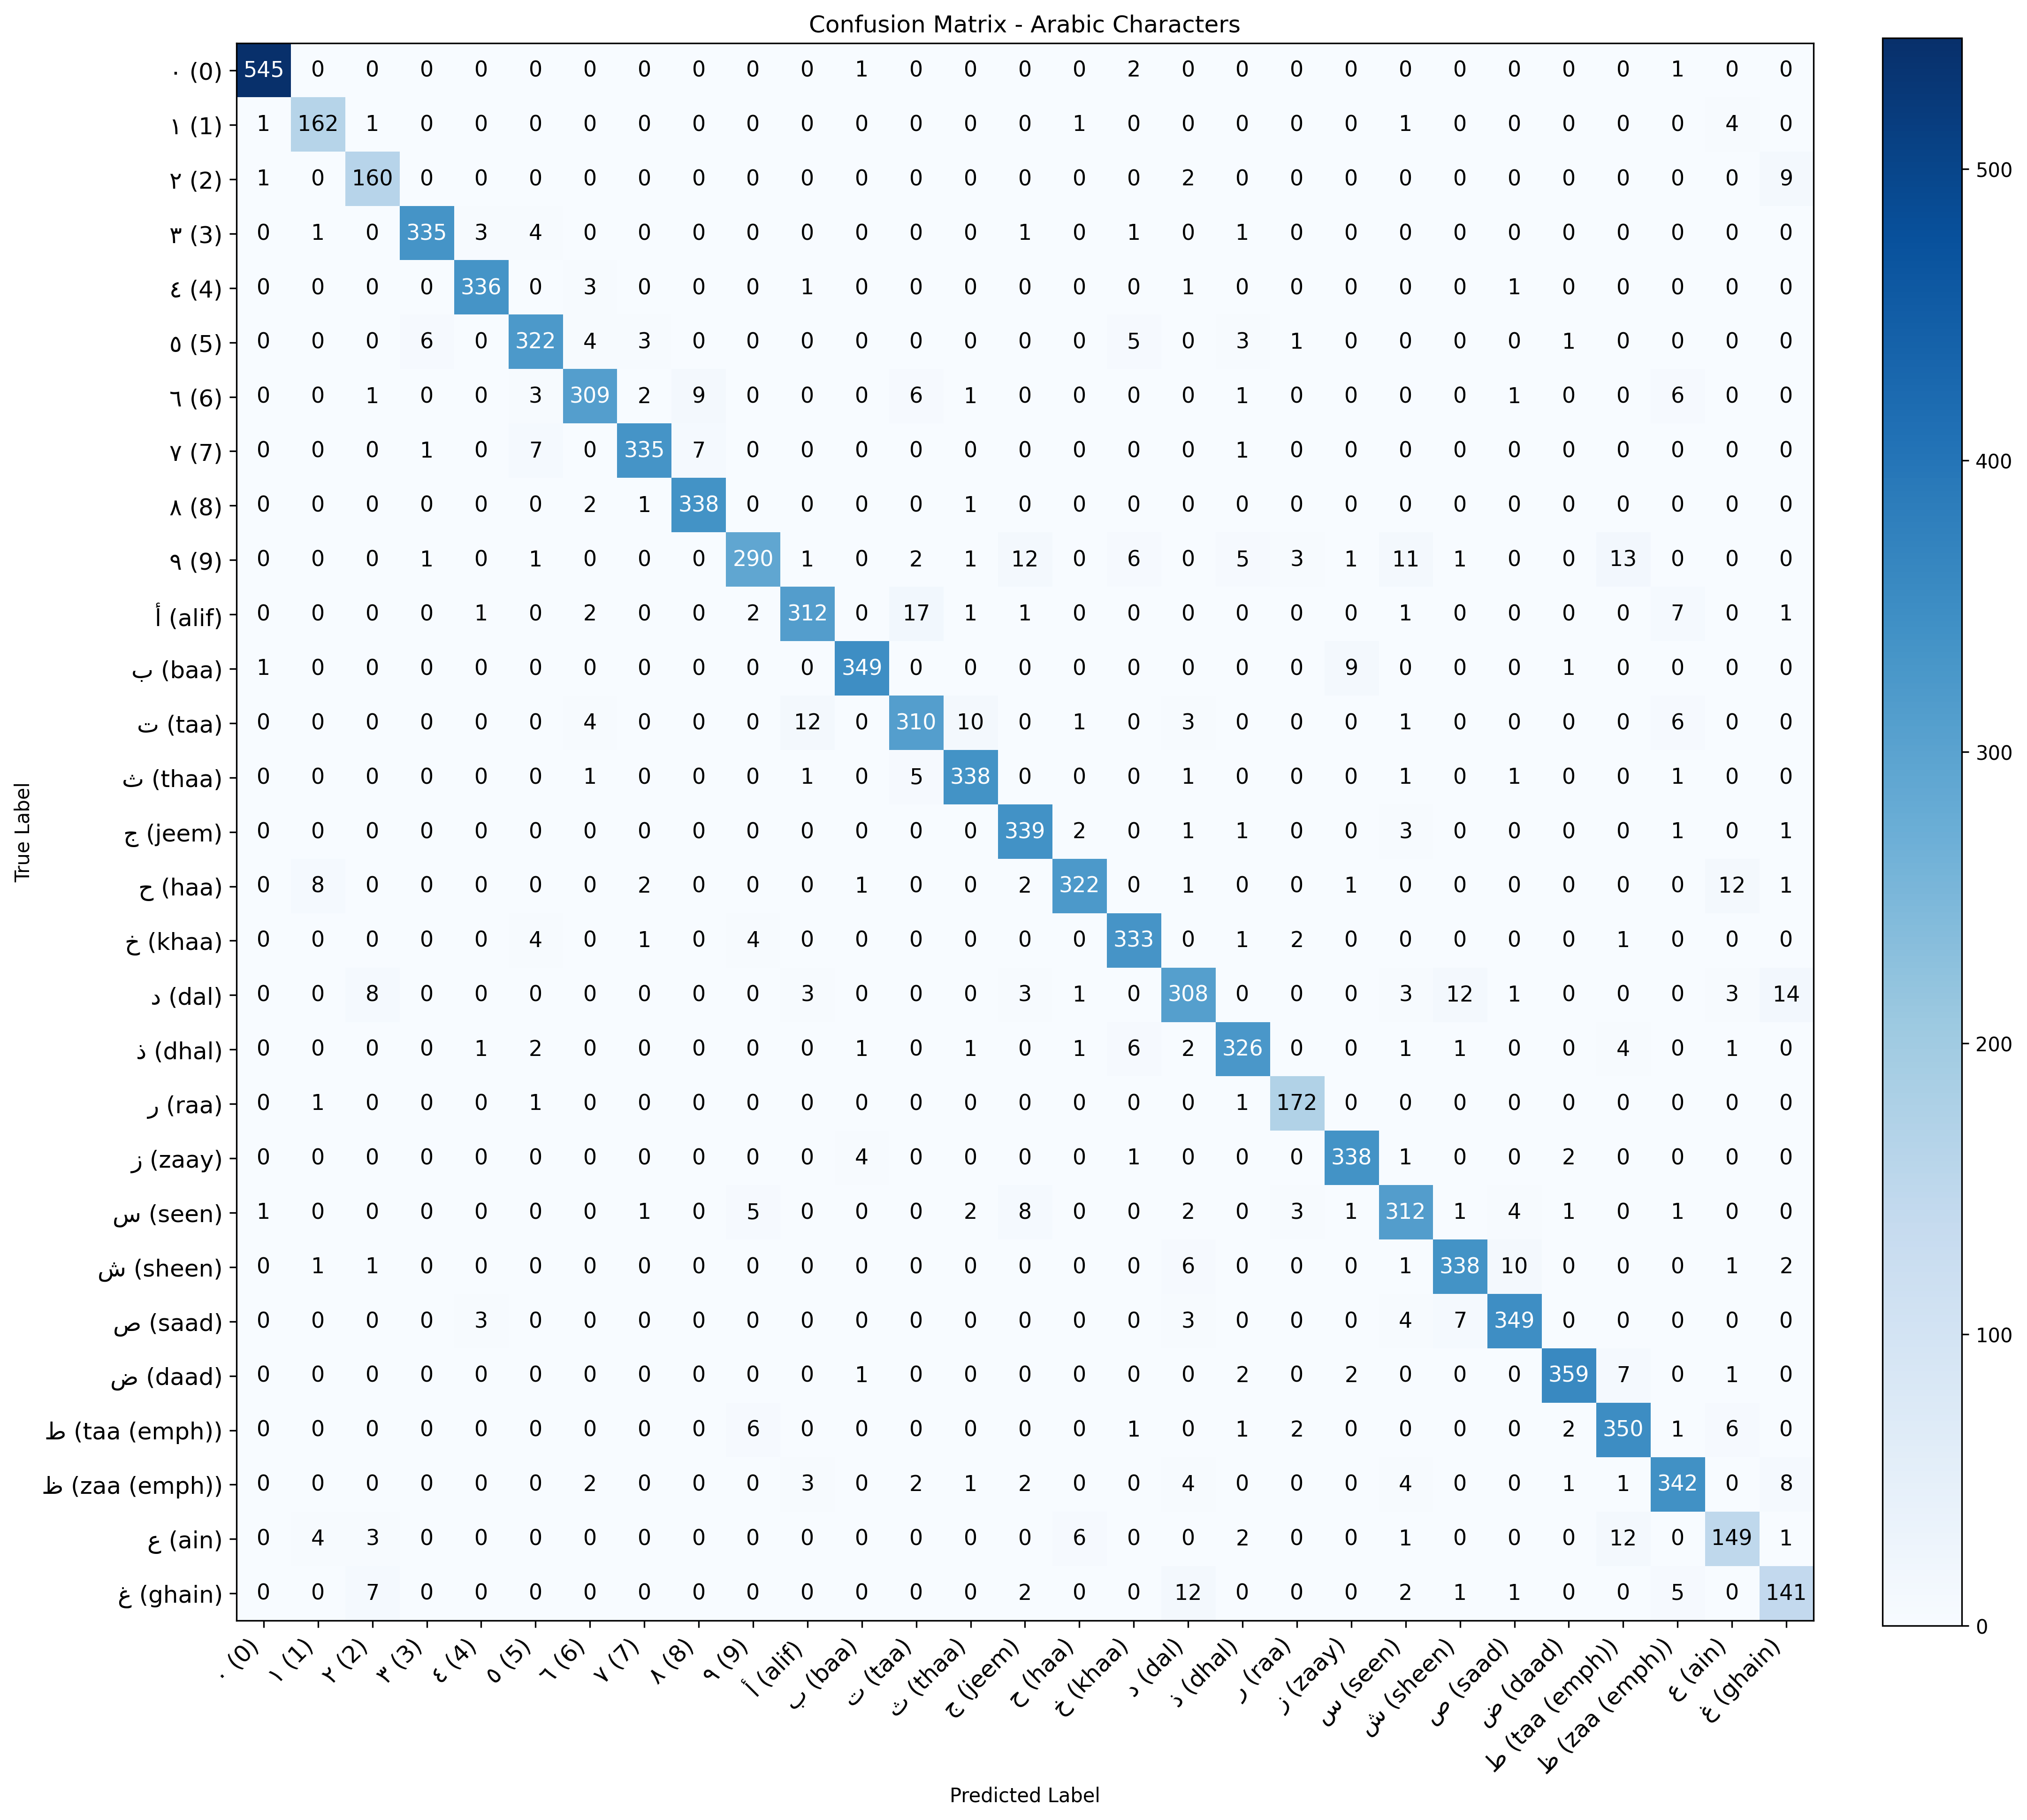

✅ Confusion matrix saved to: confusion_matrix.png
📋 Classification Report:

                precision    recall  f1-score   support

         ٠ (0)     0.9927    0.9927    0.9927       549
         ١ (1)     0.9153    0.9529    0.9337       170
         ٢ (2)     0.8840    0.9302    0.9065       172
         ٣ (3)     0.9767    0.9682    0.9724       346
         ٤ (4)     0.9767    0.9825    0.9796       342
         ٥ (5)     0.9360    0.9333    0.9347       345
         ٦ (6)     0.9450    0.9115    0.9279       339
         ٧ (7)     0.9710    0.9544    0.9626       351
         ٨ (8)     0.9548    0.9883    0.9713       342
         ٩ (9)     0.9446    0.8333    0.8855       348
      أ (alif)     0.9369    0.9043    0.9204       345
       ب (baa)     0.9776    0.9694    0.9735       360
       ت (taa)     0.9064    0.8934    0.8999       347
      ث (thaa)     0.9494    0.9685    0.9589       349
      ج (jeem)     0.9162    0.9741    0.9443       348
       ح (haa)     0.9641  

/tmp/ipykernel_35/2687404042.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', end - start)


✅ ROC group saved to: roc_curves_page1.png


<Figure size 640x480 with 0 Axes>

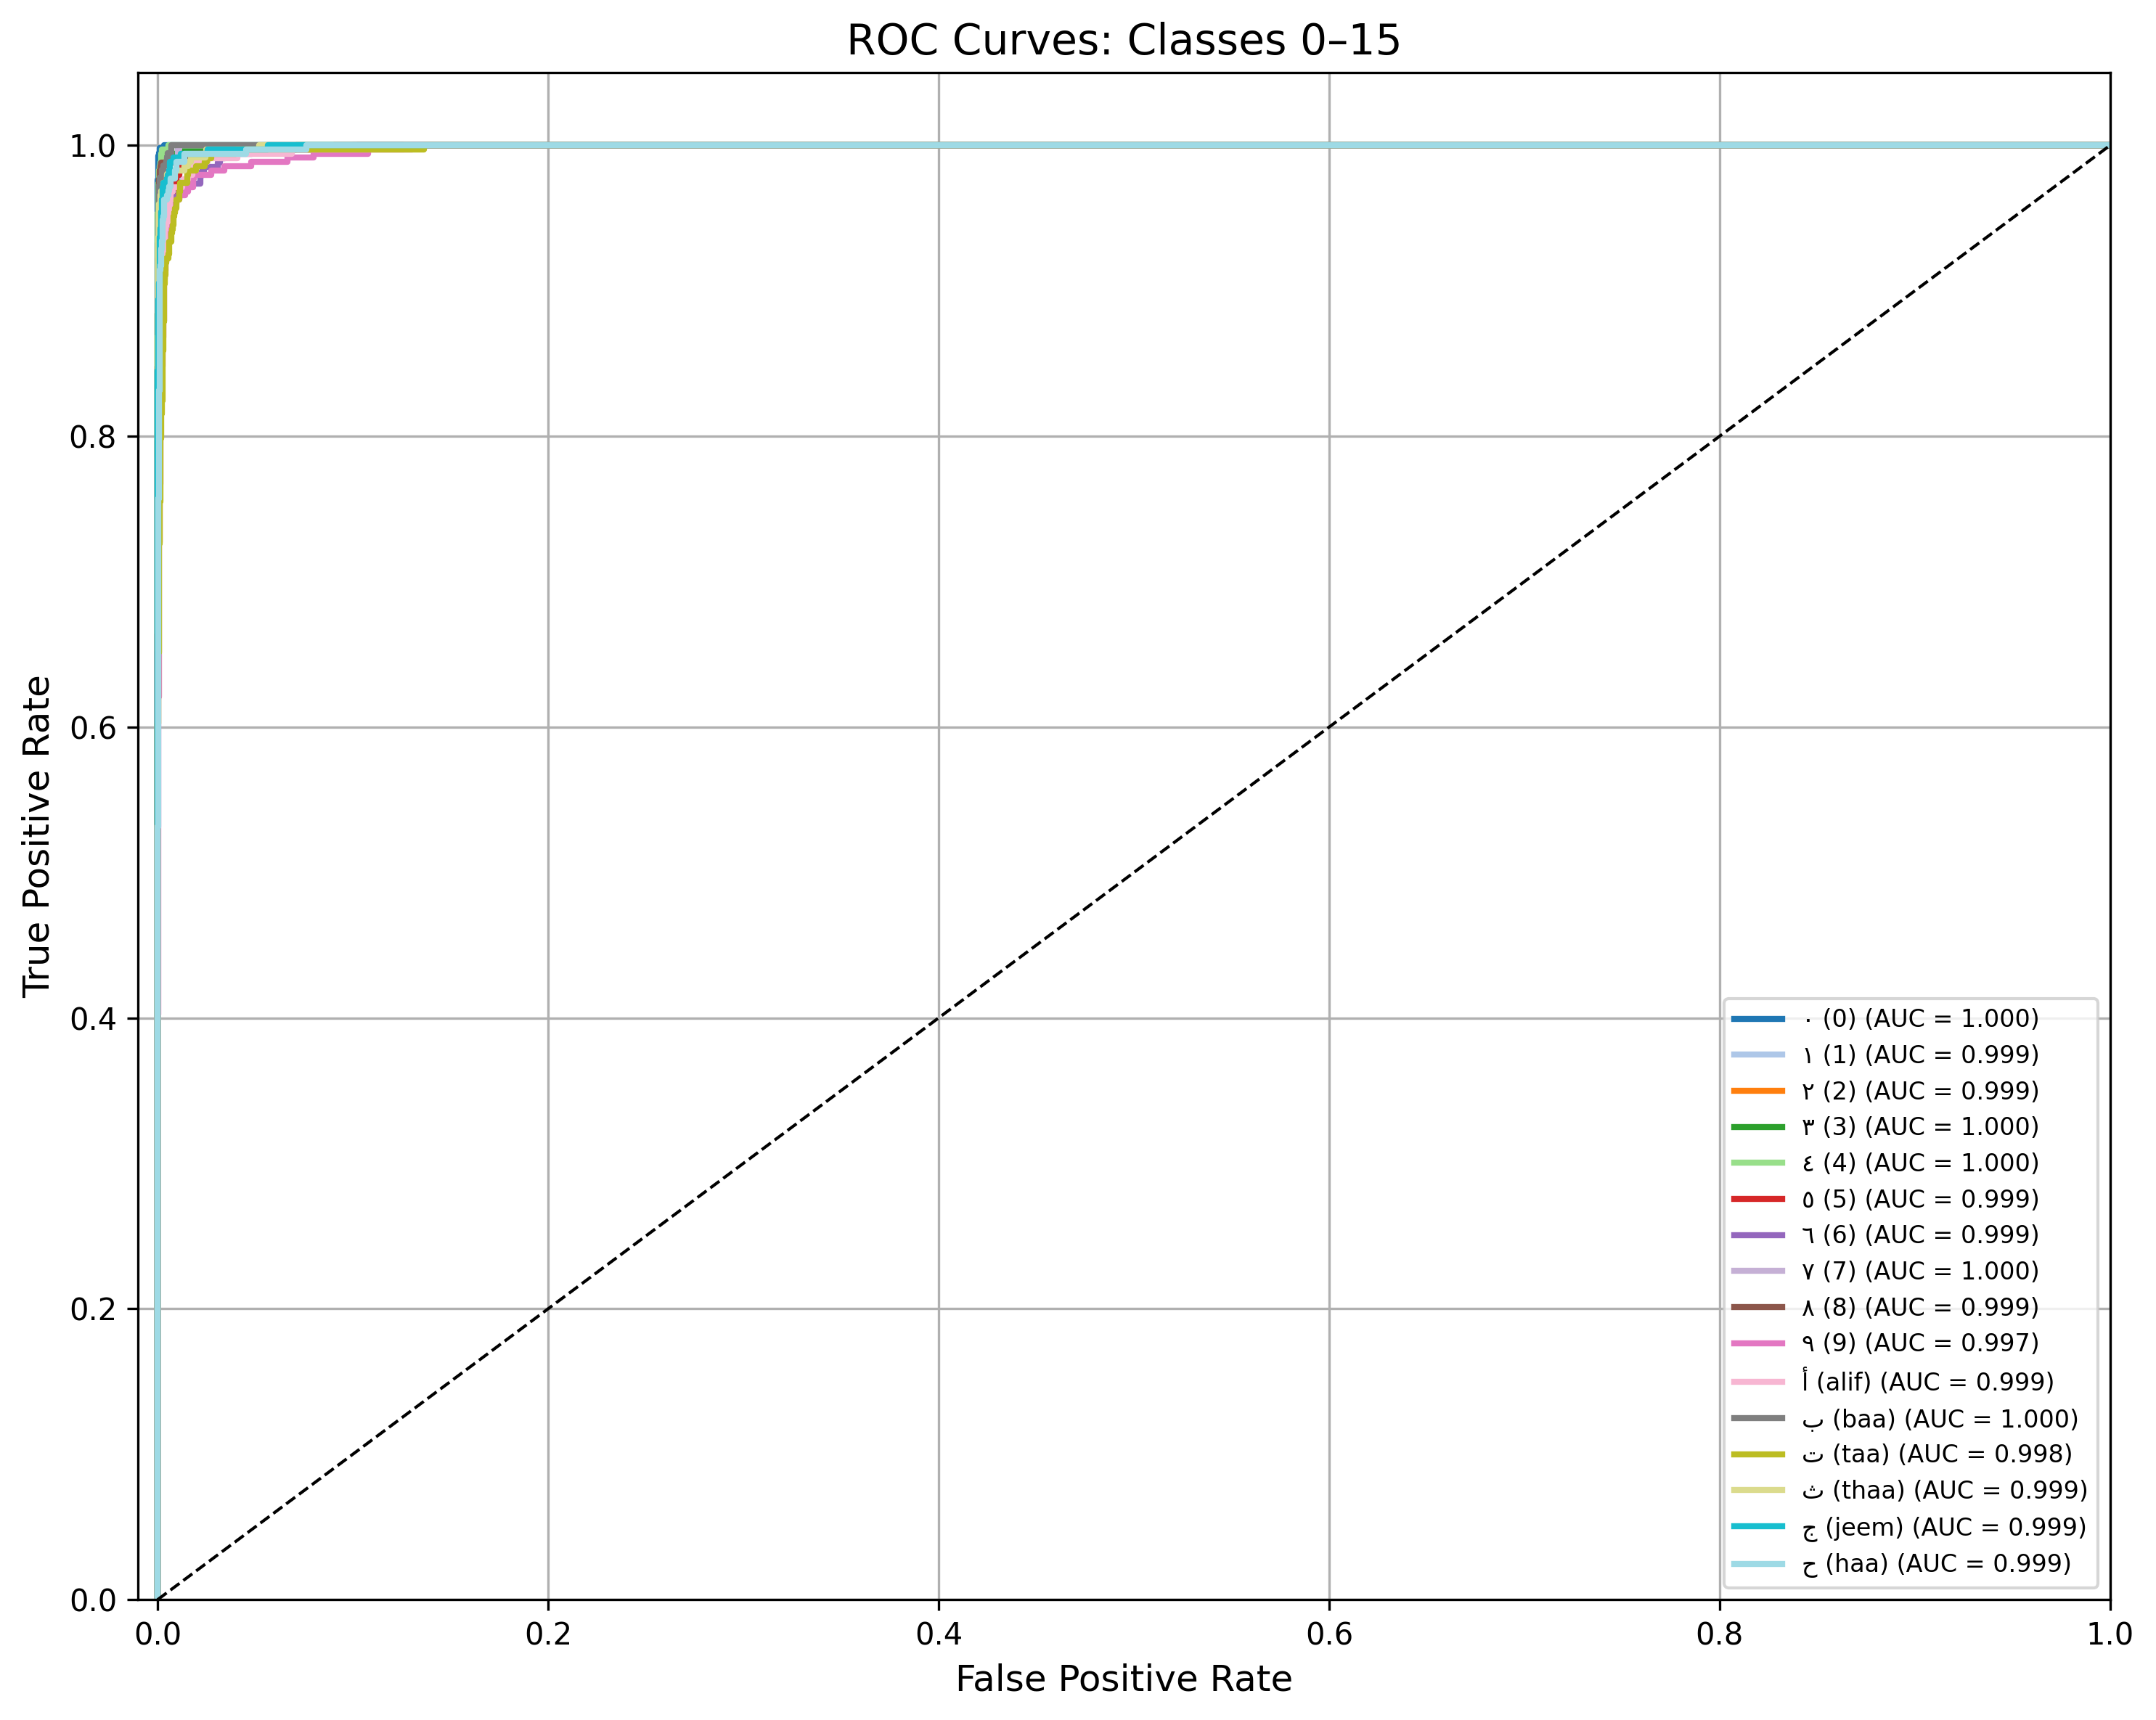

/tmp/ipykernel_35/2687404042.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', end - start)


✅ ROC group saved to: roc_curves_page2.png


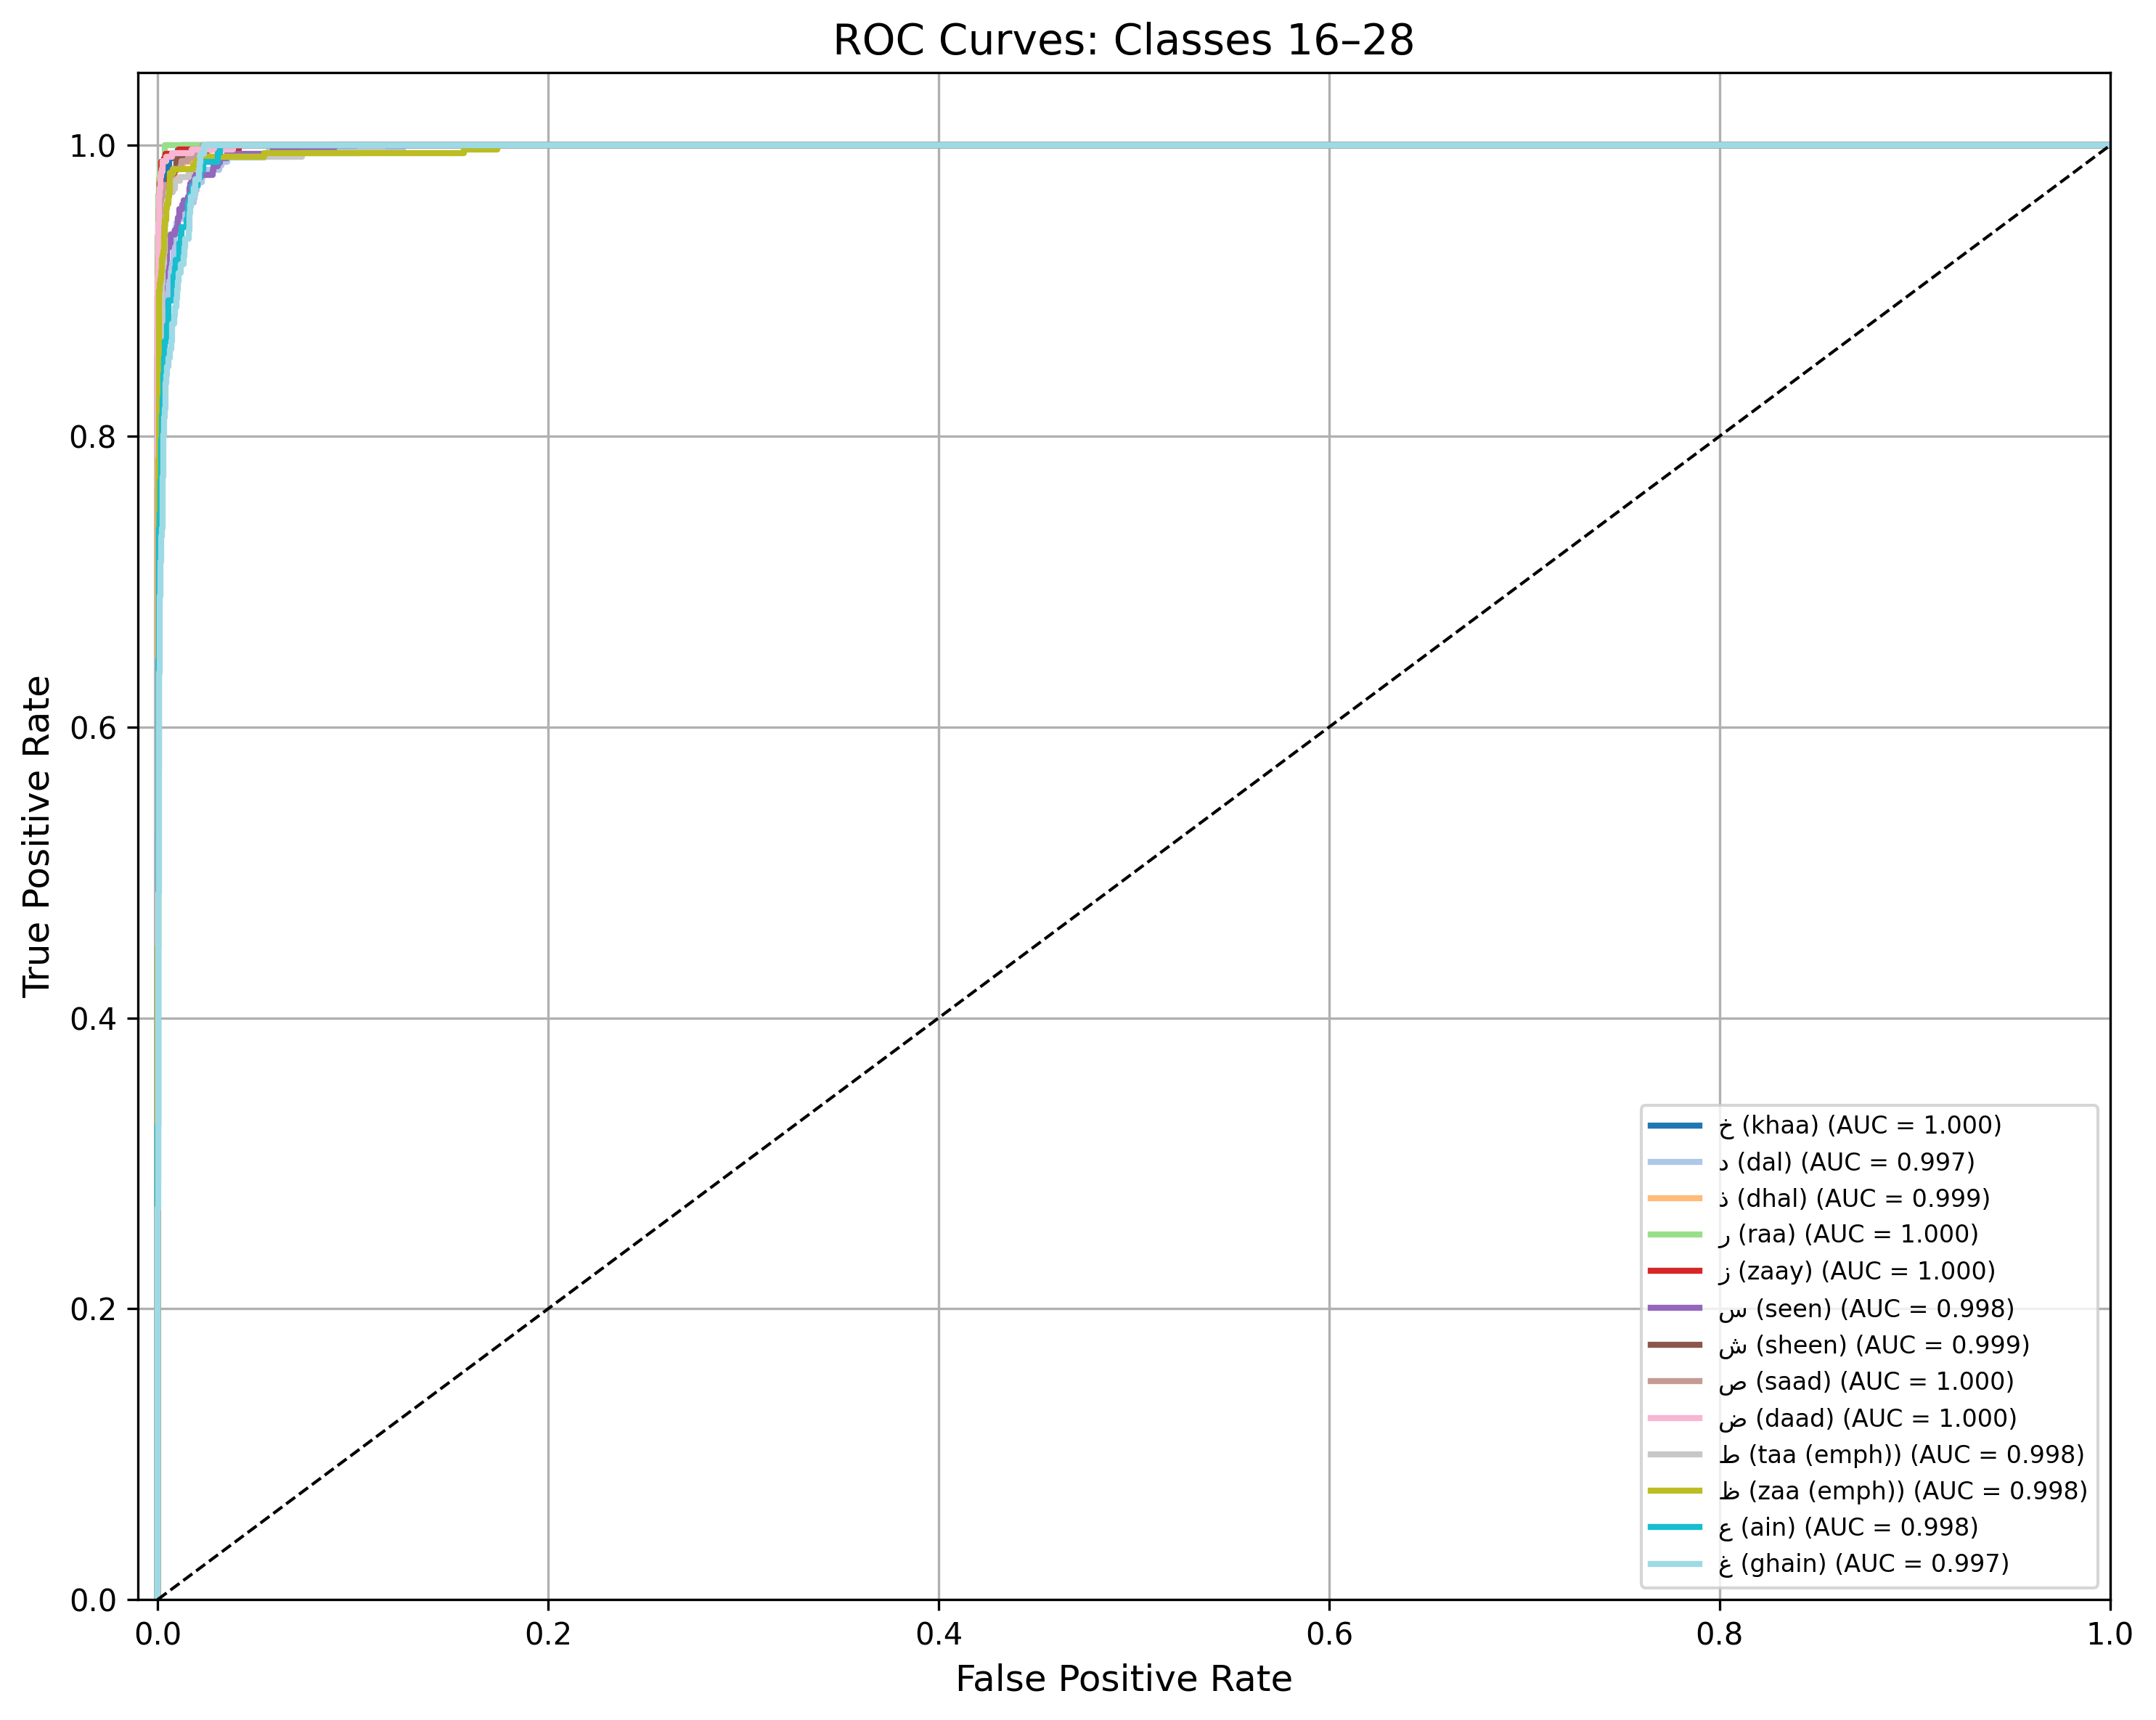

✅ Classification metrics saved to: metrics.csv


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize
from math import ceil

# Arabic + English Labels for HIJJA
arabic_labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩',
                 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر',
                 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
english_utterances = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      'alif', 'baa', 'taa', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'dhal', 'raa',
                      'zaay', 'seen', 'sheen', 'saad', 'daad', 'taa (emph)', 'zaa (emph)', 'ain', 'ghain']
combined_labels = [f"{a} ({e})" for a, e in zip(arabic_labels, english_utterances)]

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,
    show_grid=False
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150, group_size=16, export_base_path=None):
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    total_groups = ceil(num_classes / group_size)

    for group_idx in range(total_groups):
        start = group_idx * group_size
        end = min((group_idx + 1) * group_size, num_classes)

        plt.figure(figsize=(10, 8), dpi=dpi)
        colors = plt.cm.get_cmap('tab20', end - start)

        for i, class_i in enumerate(range(start, end)):
            if len(np.unique(y_true_bin[:, class_i])) > 1:
                fpr, tpr, _ = roc_curve(y_true_bin[:, class_i], y_pred_probs[:, class_i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=colors(i), lw=2,
                         label=f"{class_names[class_i]} (AUC = {roc_auc:.3f})")
            else:
                print(f"Skipping ROC for class '{class_names[class_i]}' (no positives).")

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curves: Classes {start}–{end - 1}', fontsize=14)
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True)
        plt.tight_layout()

        if export_base_path:
            path = f"{export_base_path}_page{group_idx+1}.png"
            plt.savefig(path, dpi=dpi)
            print(f"✅ ROC group saved to: {path}")

        plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Use Arabic + English combined labels
    class_names = combined_labels
    num_classes = len(class_names)

    # 1. Confusion Matrix
    if plot_cm:
        dpi_val = 300 if export_cm_path else 150
        plot_confusion_matrix_general(
            y_true, y_pred, class_labels=class_names,
            title="Confusion Matrix - Arabic Characters",
            normalize=normalize_cm,
            dpi=dpi_val
        )
        if export_cm_path:
            fig = plt.gcf()
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

    # 2. Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Precision/Recall/F1 Scores
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            plot_roc_curves(
                y_true=y_true,
                y_pred_probs=y_pred_probs,
                class_names=class_names,
                dpi=300 if export_roc_path else 150,
                group_size=16,
                export_base_path=export_roc_path.replace(".png", "") if export_roc_path else None
            )
        else:
            print("⚠️ ROC plotting skipped due to prediction shape mismatch.")

    # 5. Export CSV
    if export_metrics_path:
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }

# Usage:
results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",
    export_cm_path="confusion_matrix.png",
    export_roc_path="roc_curves.png"
)


In [38]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Predict and true labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Arabic + English label list
arabic_labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', 
                 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
                 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
english_utterances = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                      'alif', 'baa', 'taa', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'dhal', 'raa',
                      'zaay', 'seen', 'sheen', 'saad', 'daad', 'taa (emph)', 'zaa (emph)', 'ain', 'ghain']
combined_labels = [f"{a} ({e})" for a, e in zip(arabic_labels, english_utterances)]

# Print classification report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=combined_labels, digits=4))

# Extract and print macro and weighted metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Display scores
print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
📋 Classification Report:

                precision    recall  f1-score   support

         ٠ (0)     0.9927    0.9927    0.9927       549
         ١ (1)     0.9153    0.9529    0.9337       170
         ٢ (2)     0.8840    0.9302    0.9065       172
         ٣ (3)     0.9767    0.9682    0.9724       346
         ٤ (4)     0.9767    0.9825    0.9796       342
         ٥ (5)     0.9360    0.9333    0.9347       345
         ٦ (6)     0.9450    0.9115    0.9279       339
         ٧ (7)     0.9710    0.9544    0.9626       351
         ٨ (8)     0.9548    0.9883    0.9713       342
         ٩ (9)     0.9446    0.8333    0.8855       348
      أ (alif)     0.9369    0.9043    0.9204       345
       ب (baa)     0.9776    0.9694    0.9735       360
       ت (taa)     0.9064    0.8934    0.8999       347
      ث (thaa)     0.9494    0.9685    0.9589       349
      ج (jeem)     0.9162    0.9741    0.9443       348
       ح (haa)     0.9641    0.9200